<a href="https://colab.research.google.com/github/dmit-vuk/dl_mmp_msu/blob/main/dl_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Исследование распределений градиентов в CNN**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid') 

Исследования будем проводить на сети ResNet18. Она состоит из блоков, каждый из которых состоит из двух уровней типа Conv + Activate + Conv + SkipConnection. В качестве функции активации возьмём ReLU. После свёрточных слоёв можно вставить BatchNorm или Dropout. 

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1, use_BN=True, dropout=0.0, skip=True, activation=nn.ReLU(inplace=True)):
        super(ResidualBlock, self).__init__()
        self.skip = skip
        self.activation = activation
        if use_BN:
            self.left = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(outchannel),
                nn.Dropout(dropout),
                activation,
                nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(outchannel),
                nn.Dropout(dropout)
            )
        else:
            self.left = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.activation(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout(dropout)
            )
        if skip:
            self.shortcut = nn.Sequential()
        if (stride != 1 or inchannel != outchannel) and skip:
            if use_BN:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                    nn.Dropout(dropout),
                    nn.BatchNorm2d(outchannel)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                    nn.Dropout(dropout)
                )
            
    def forward(self, x):
        out = self.left(x)
        if self.skip:
            out = out + self.shortcut(x)
        out = self.activation(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10, use_BN=True, dropout=0.0, width=1, depth=2, skip=True, init=None, activation=nn.ReLU()):
        super(ResNet, self).__init__()
        self.inchannel = 32*width
        self.use_BN = use_BN
        self.activation = activation
        self.dropout = dropout
        self.skip = skip
        if use_BN:
            self.conv1 = nn.Sequential(
                nn.Conv2d(1, 32*width, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout(dropout),
                nn.BatchNorm2d(32*width),
                activation
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(1, 32*width, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout(dropout),
                activation
            )
        self.layer1 = self.make_layer(ResidualBlock, 32*width, depth, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 64*width, depth, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 128*width, depth, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 256*width, depth, stride=2)        
        self.fc = nn.Linear(256*width, num_classes)
        if init is not None:
            self.init_weights(init)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride, self.use_BN, self.dropout, self.skip, self.activation))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def init_weights(self, init):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init == 'kaiming':
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif init == 'xavier':
                    nn.init.xavier_normal_(m.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
def ResNet18(num_classes=10, use_BN=True, dropout=0.0, width=1, depth=2, skip=True, init=None, activation=nn.ReLU()):
    return ResNet(ResidualBlock, num_classes=num_classes, use_BN=use_BN, dropout=dropout, width=width, depth=depth, skip=skip, init=init, activation=activation)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 512

#prepare dataset and preprocessing
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

Эксперименты проведём на трёх датасетах: MNIST, FashionMNIST и Kuzushiji-MNIST, состоящие из чёрно-белых изображений размера $28 \times 28$

In [8]:
trainset_mnist = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset_mnist = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=100, shuffle=False, num_workers=2)

In [10]:
trainset_fashin_mnist = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform_train)
trainloader_fashin_mnist = torch.utils.data.DataLoader(trainset_fashin_mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset_fashin_mnist = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
testloader_fashin_mnist = torch.utils.data.DataLoader(testset_fashin_mnist, batch_size=100, shuffle=False, num_workers=2)

In [11]:
trainset_kmnist = torchvision.datasets.KMNIST(root='../data', train=True, download=True, transform=transform_train)
trainloader_kmnist = torch.utils.data.DataLoader(trainset_kmnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset_kmnist = torchvision.datasets.KMNIST(root='../data', train=False, download=True, transform=transform_test)
testloader_kmnist = torch.utils.data.DataLoader(testset_kmnist, batch_size=100, shuffle=False, num_workers=2)

В качестве функции потерь используем энтропию

In [12]:
criterion = nn.CrossEntropyLoss()

Напишем функции обучения, отрисовки градиентов и оценки качества на тесте. Будем рисовать градиенты для верхних свёрточных слоёв каждого блока для 1 эпохи и 10. 

In [13]:
def train(model, trainloader, testloader, num_epoch, criterion, optimizer):
    grads = {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:0}, 3:{0:0, 1:0}, 4:{0:0, 1:0}}
    for epoch in range(num_epoch):
        total = 0
        if epoch==0:
            i = 0
        elif epoch == num_epoch-1:
            i = 1
        else:
            i =-1
        for images, labels in trainloader:
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if i >= 0:
                grads[0][i] += model.conv1[0].weight.grad.reshape(-1)
                grads[1][i] += model.layer1[0].left[0].weight.grad.reshape(-1)
                grads[2][i] += model.layer2[0].left[0].weight.grad.reshape(-1)
                grads[3][i] += model.layer3[0].left[0].weight.grad.reshape(-1)
                grads[4][i] += model.layer4[0].left[0].weight.grad.reshape(-1)

            total += 1
        if i >= 0:
          for key in range(5):
              grads[key][i] /= total
    return grads

In [14]:
def plot_grads(grads, title):
    
    plt.figure(figsize=(35, 13))
    plt.suptitle(title, fontsize=15)
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title(f'layer{i%5 + 1}, epoch{i // 5 * 10}')
        plt.hist(grads[i%5][i//5].cpu(), bins = 20)
        plt.grid(True)
        plt.ylabel('Count',  fontsize=15)
        plt.xlabel('Grad magnitude',  fontsize=15)

In [15]:
def accuracy(net, testloader):
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

Обучать сети будем 10 эпох. По умолчанию используется оптимизатор Adam с параметрами learning rate = 3e-5, веса свёрток инициализируются по дефолту PyTorch.

Проведём следующие эксперименты:
*   Без BatchNorm, Dropout и SkipConnection
*   SkipConnection без BatchNorm и Dropout
*   SkipConnection + BatchNorm без Dropout
*   SkipConnection + Dropout(0.2) без BatchNorm
*   Широкая + SkipConnection + BatchNorm без Dropout
*   Менее глубокая SkipConnection + BatchNorm без Dropout
*   Инициализация Xavier и Kaiming, SkipConnection + BatchNorm без Dropout
*   SGD, SkipConnection + BatchNorm без Dropout
*   Sigmoid, SkipConnection + BatchNorm без Dropout



##Без всего

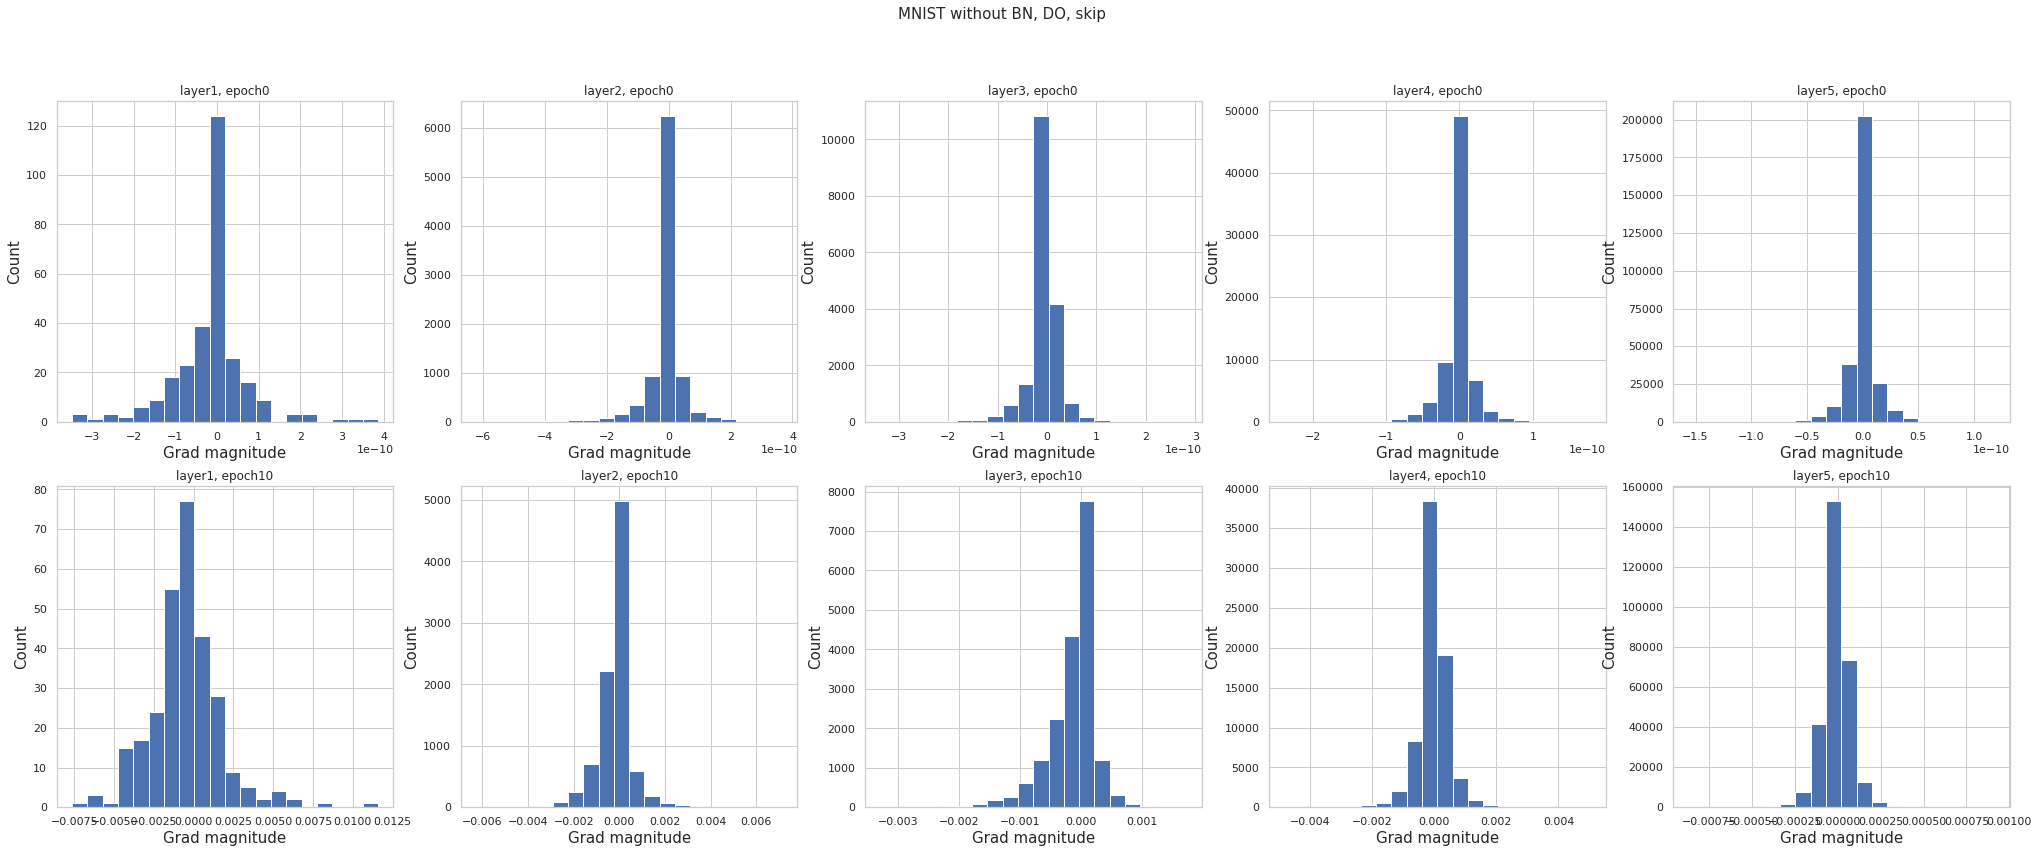

In [ ]:
net = ResNet18(use_BN=False, dropout=0, skip=False).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST without BN, DO, skip')

In [ ]:
accuracy(net, testloader_mnist)

Test's ac is: 81.890%


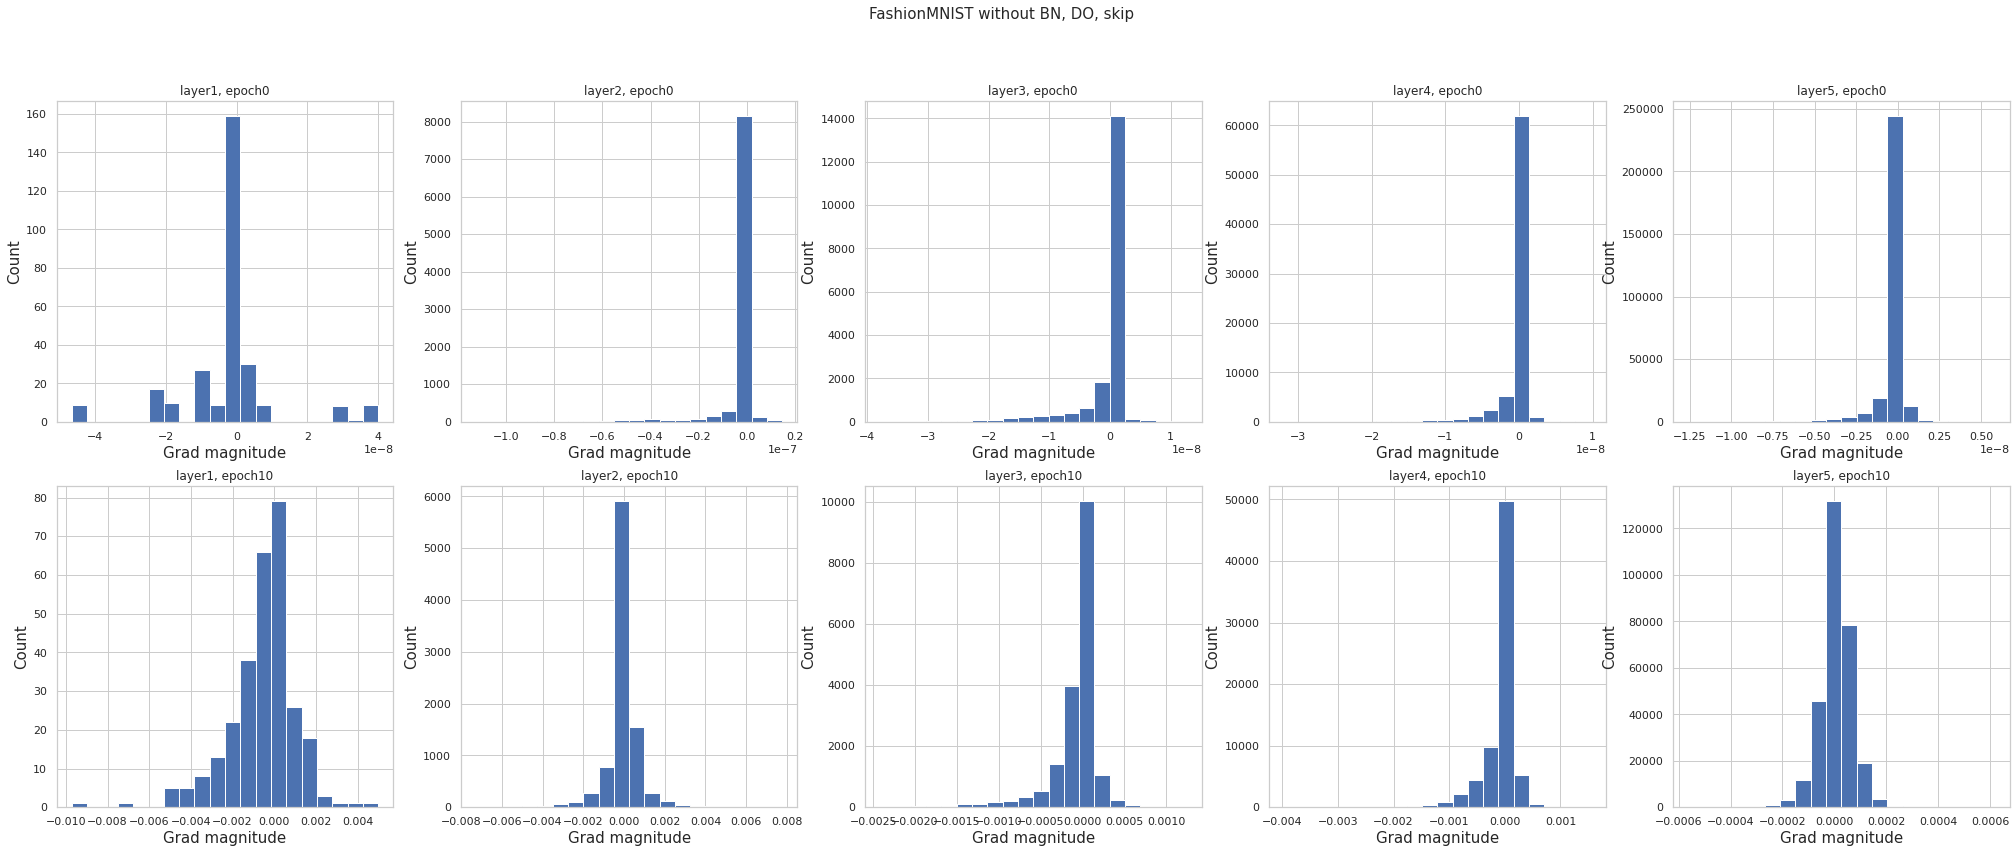

In [ ]:
net = ResNet18(use_BN=False, dropout=0, skip=False).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST without BN, DO, skip')

In [ ]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 67.650%


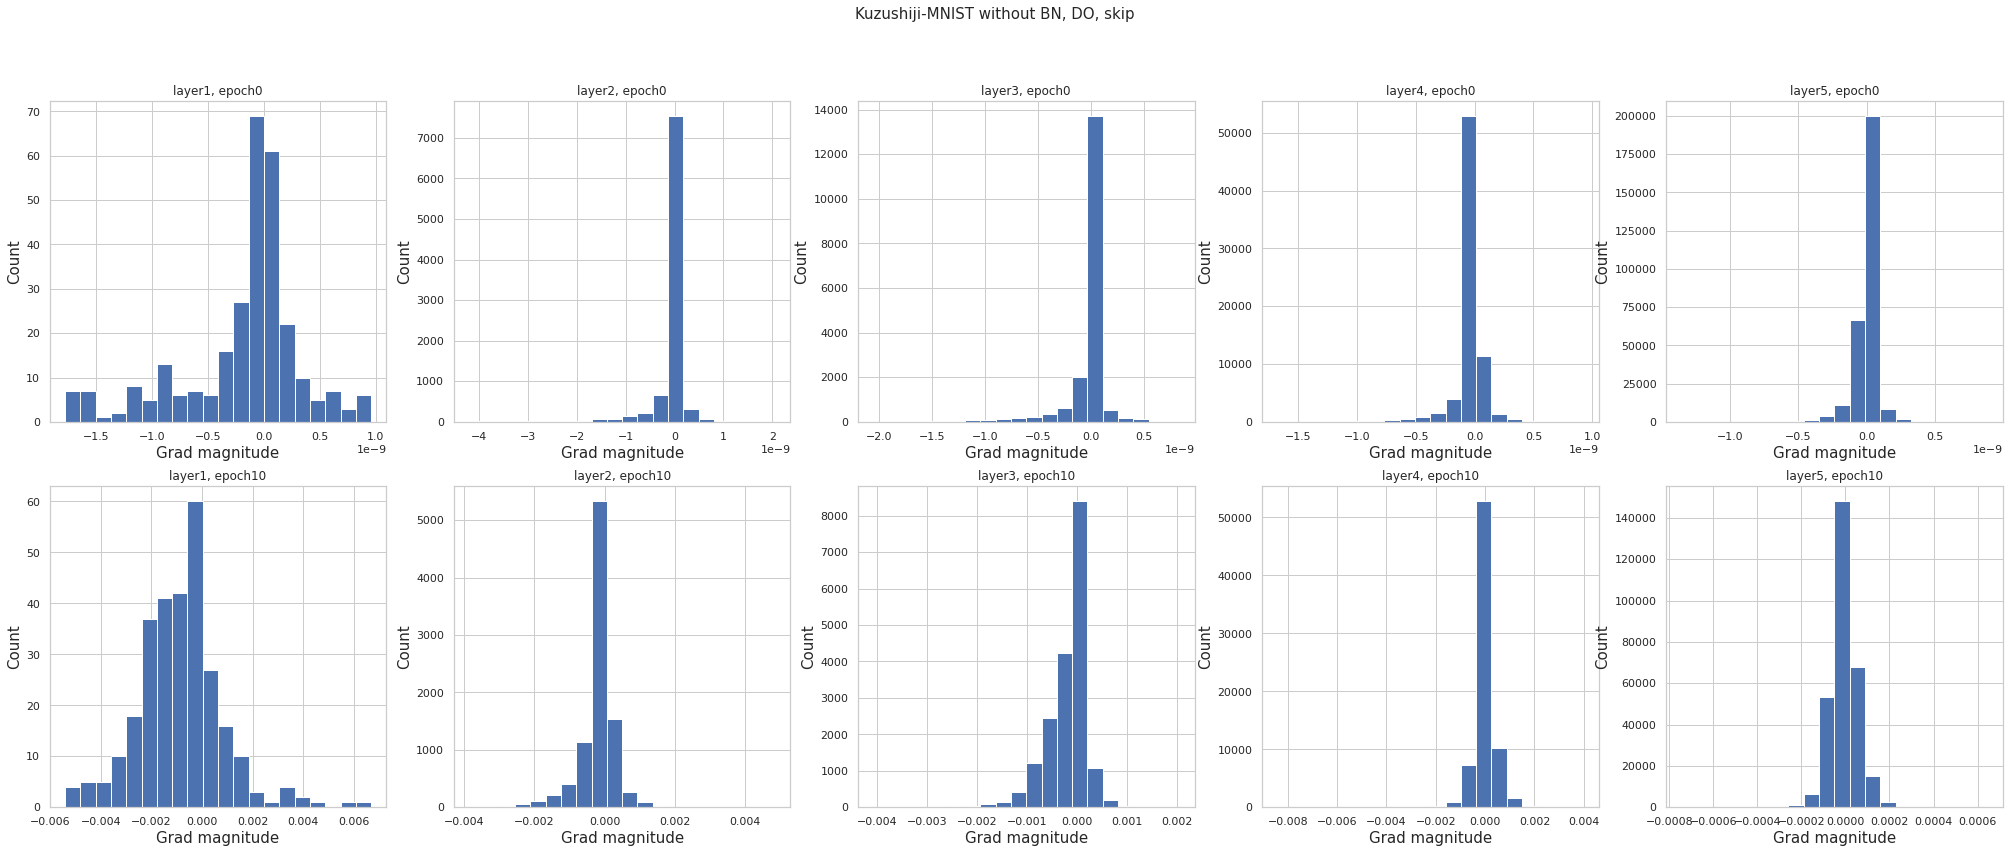

In [ ]:
net = ResNet18(use_BN=False, dropout=0, skip=False).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST without BN, DO, skip')

In [ ]:
accuracy(net, testloader_kmnist)

Test's ac is: 55.330%


Заметим, что градиенты без пробрасывания связей получаются очень маленькими. Следовательно сеть практически не обучается(т.к. веса изменяются на очень маленькую величину), что видно из очень низкого качества.

##Skip

Добавим skip-connection

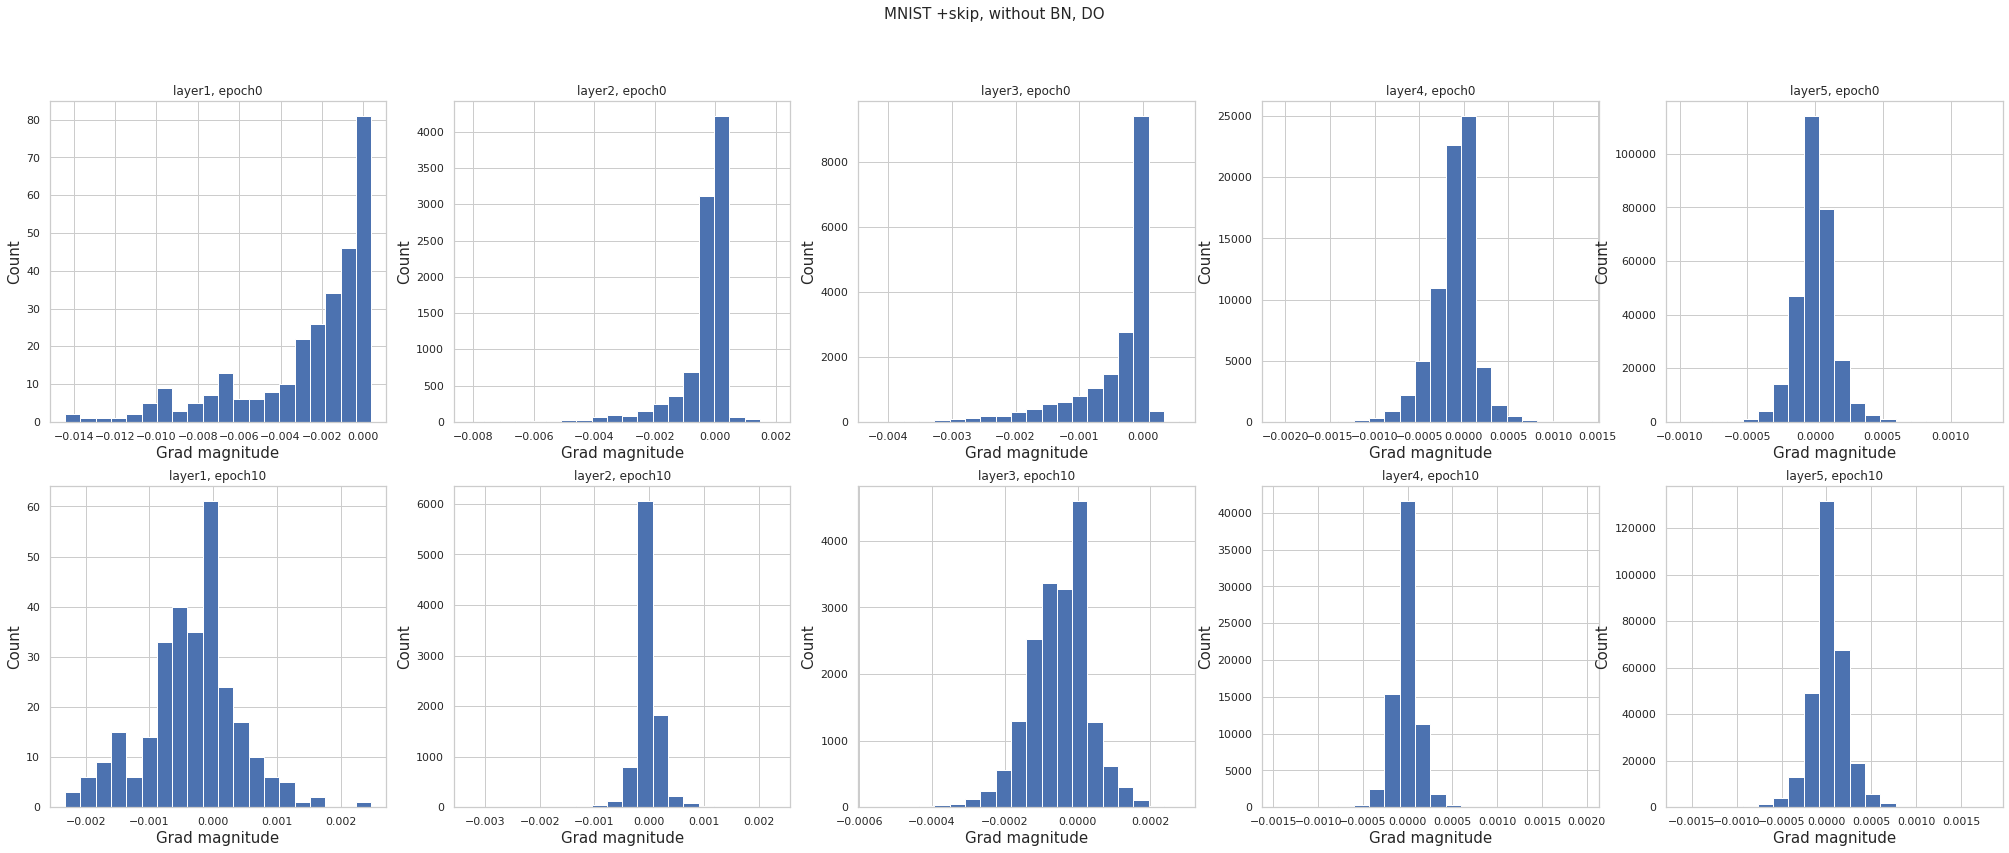

In [ ]:
net = ResNet18(use_BN=False, dropout=0, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST +skip, without BN, DO')

In [ ]:
accuracy(net, testloader_mnist)

Test's ac is: 94.290%


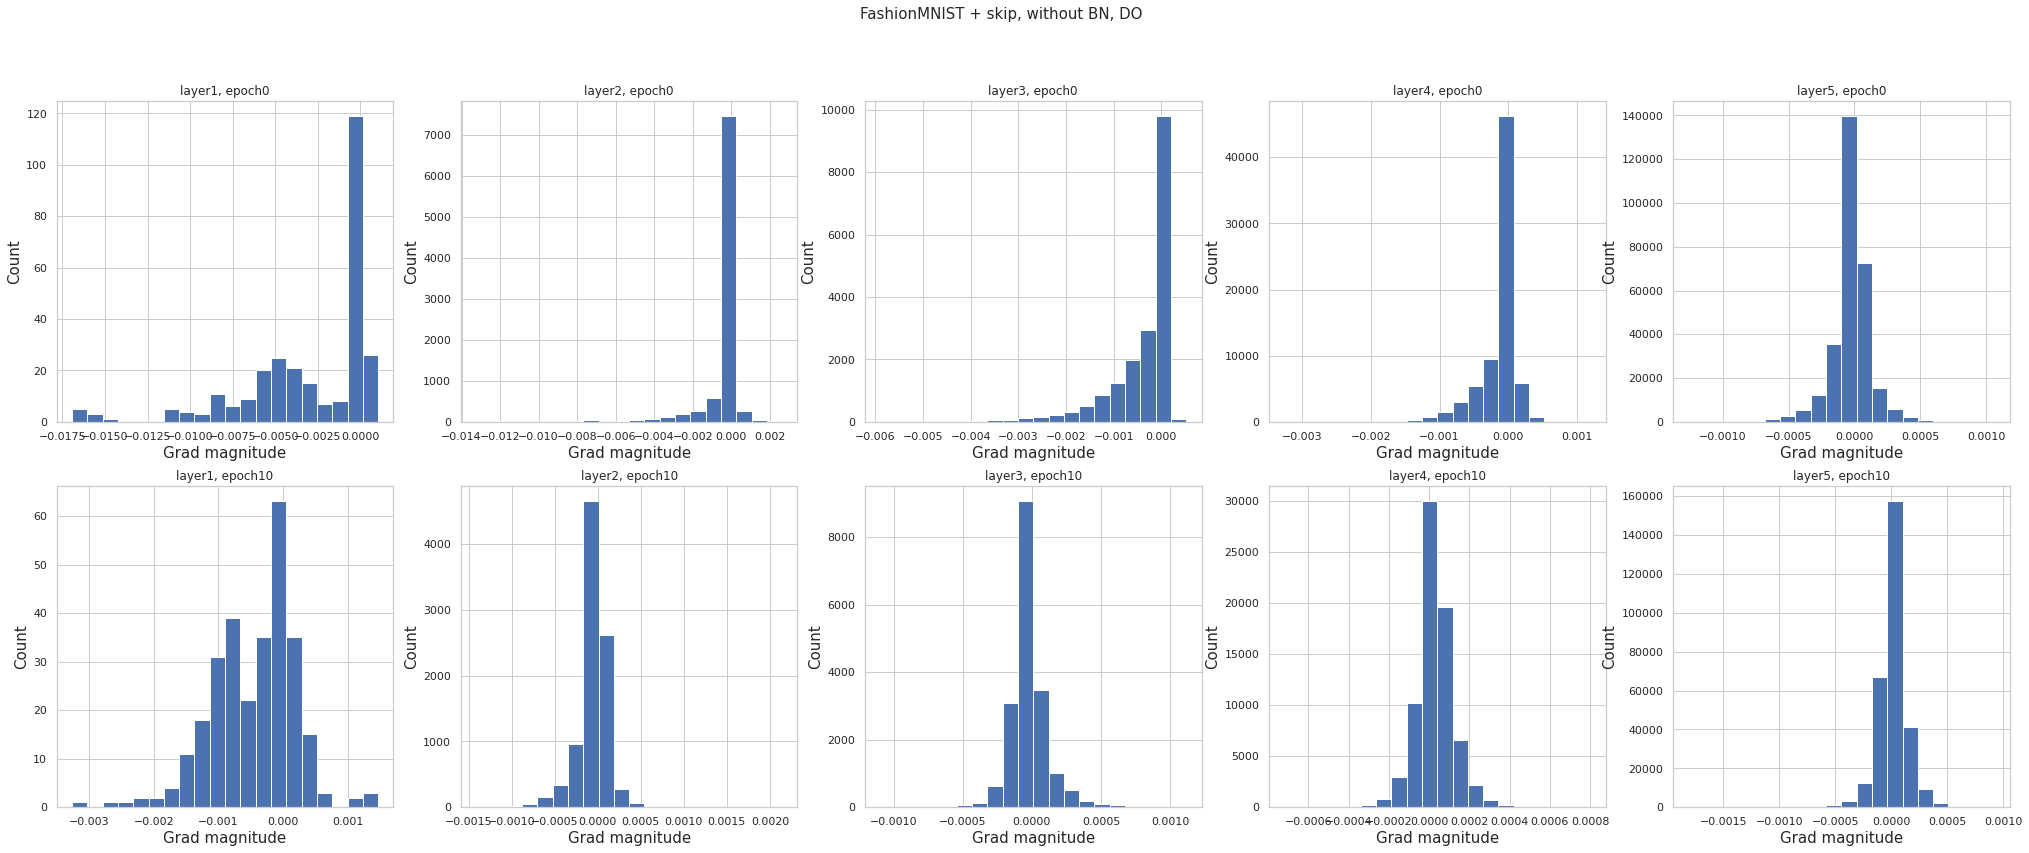

In [ ]:
net = ResNet18(use_BN=False, dropout=0, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST + skip, without BN, DO')

In [ ]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 71.600%


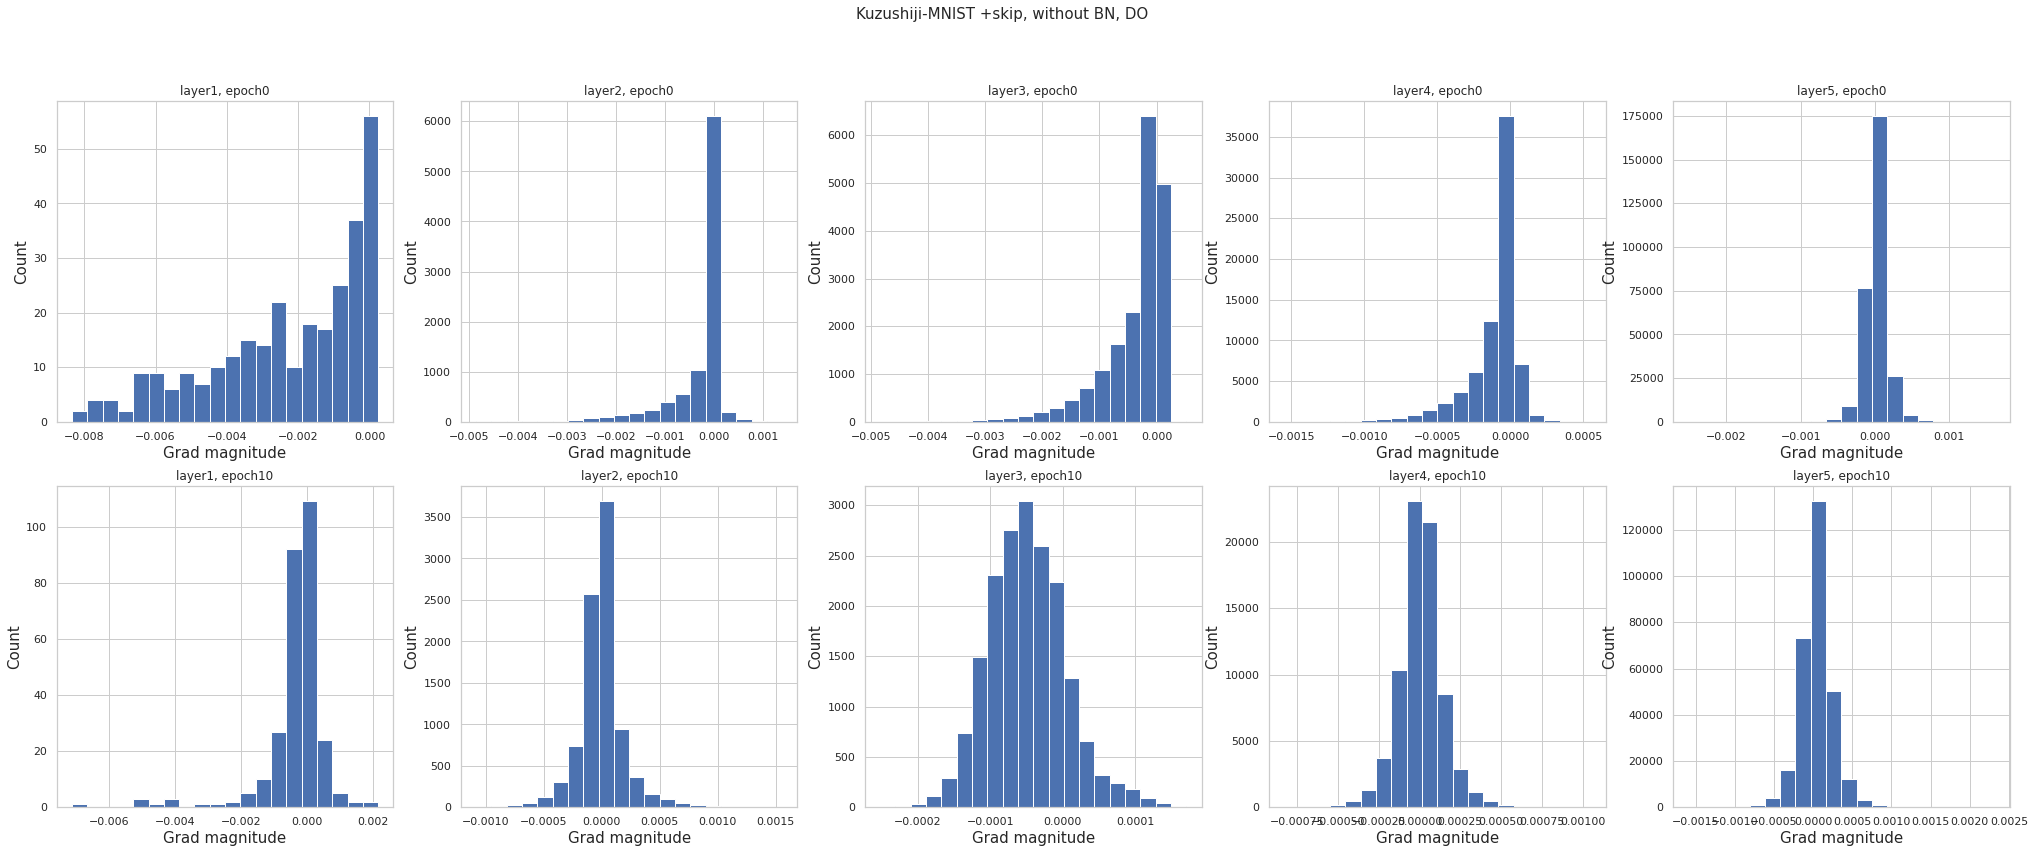

In [16]:
net = ResNet18(use_BN=False, dropout=0, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST +skip, without BN, DO')

In [17]:
accuracy(net, testloader_kmnist)

Test's ac is: 80.300%


Видно, что градиенты на первых эпохах стали намного больше, чем было в прошлом экперименте. Сеть начинает намного лучше обучаться, что видно и из качества на тесте. Но при этом распределение стало меньше быть похоже на нормальное... Вероятно это связано с тем, что мы не нормализуем наши данные на выходах свёрток. А ReLU оставляет только положительные значения, тем самым она сильно сдвигает среднее от нуля. Так же заметим, что благодаря прокидыванию связей и функции ReLU, градиенты не затухают к первым слоям.

##BN

Всюду далее будем использовать сеть со skip-connection. Проверим зависимость распределения градиентов от BatchNormd.

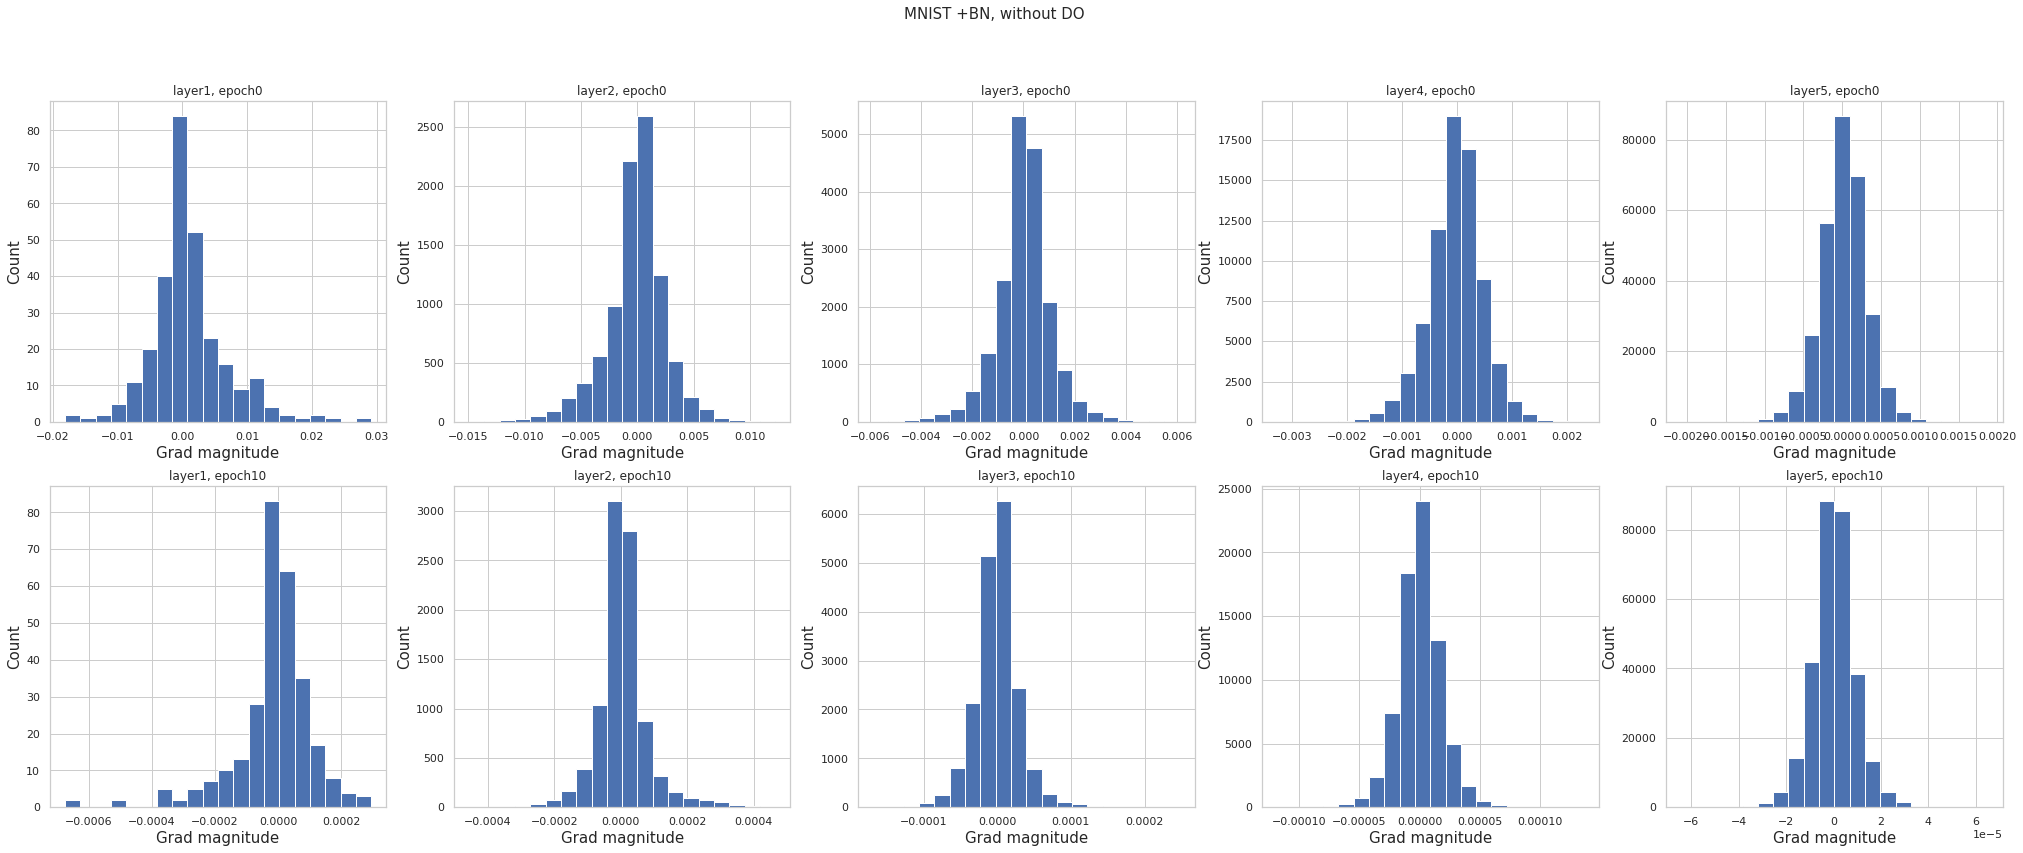

In [16]:
net = ResNet18(use_BN=True, dropout=0, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST +BN, without DO')

In [17]:
accuracy(net, testloader_mnist)

Test's ac is: 99.060%


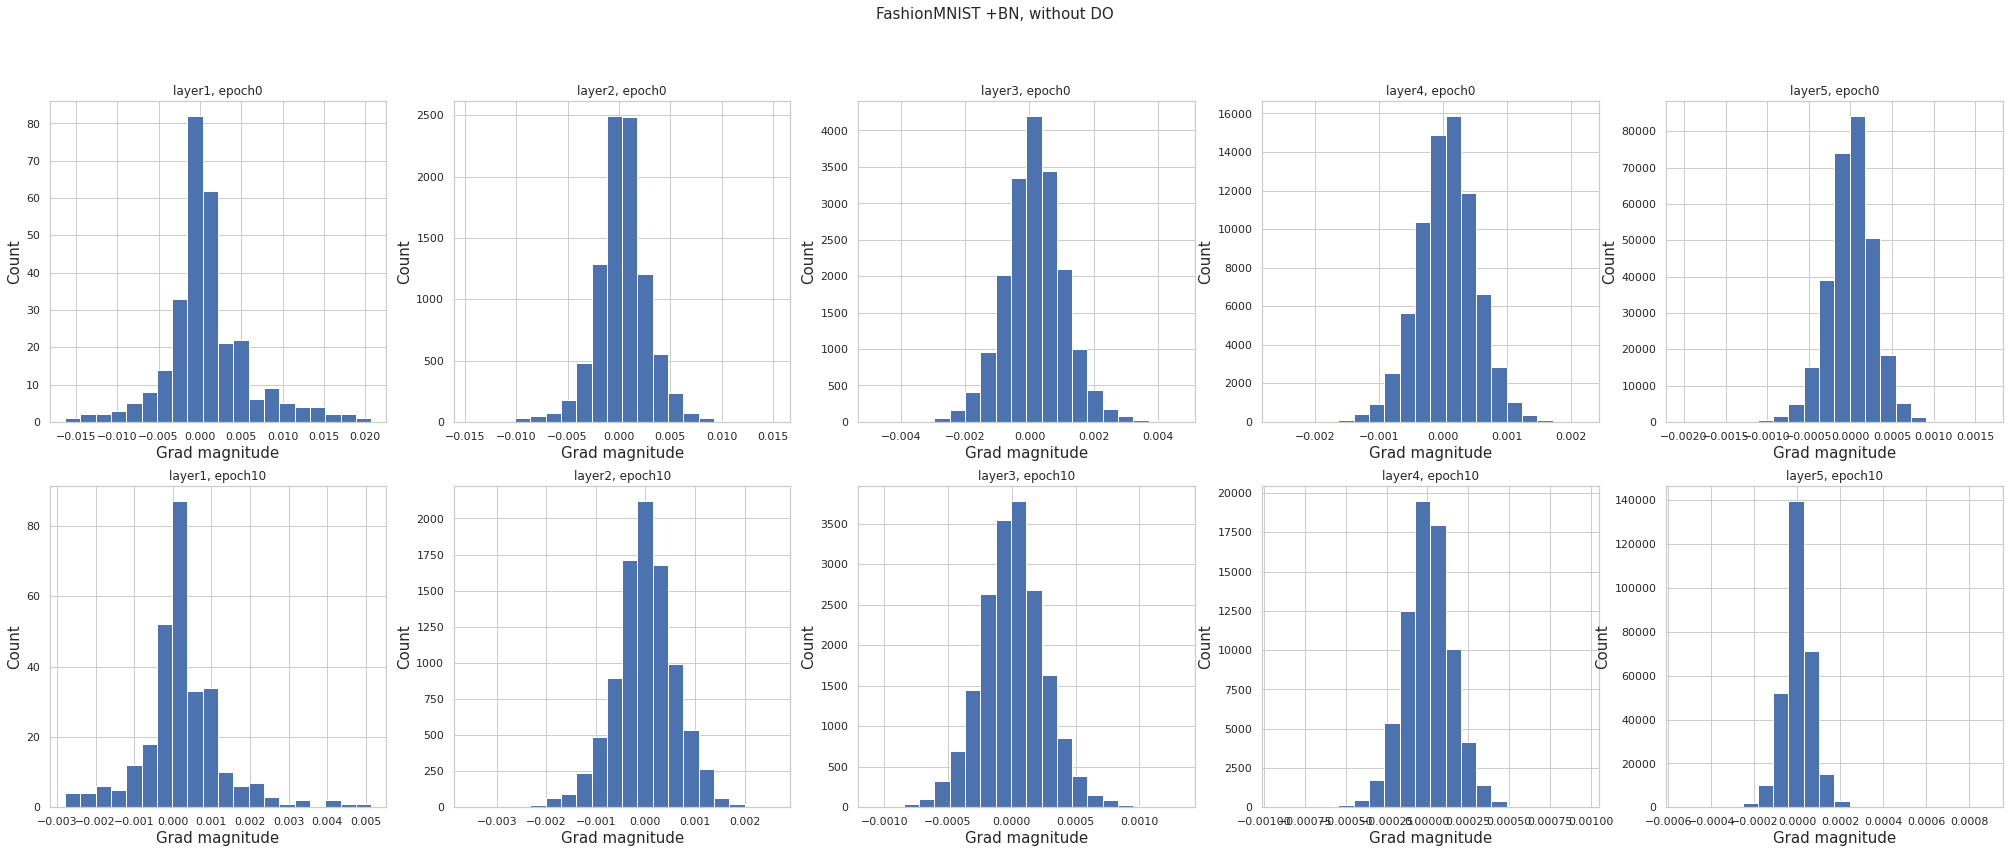

In [18]:
net = ResNet18(use_BN=True, dropout=0, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST +BN, without DO')

In [19]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 88.830%


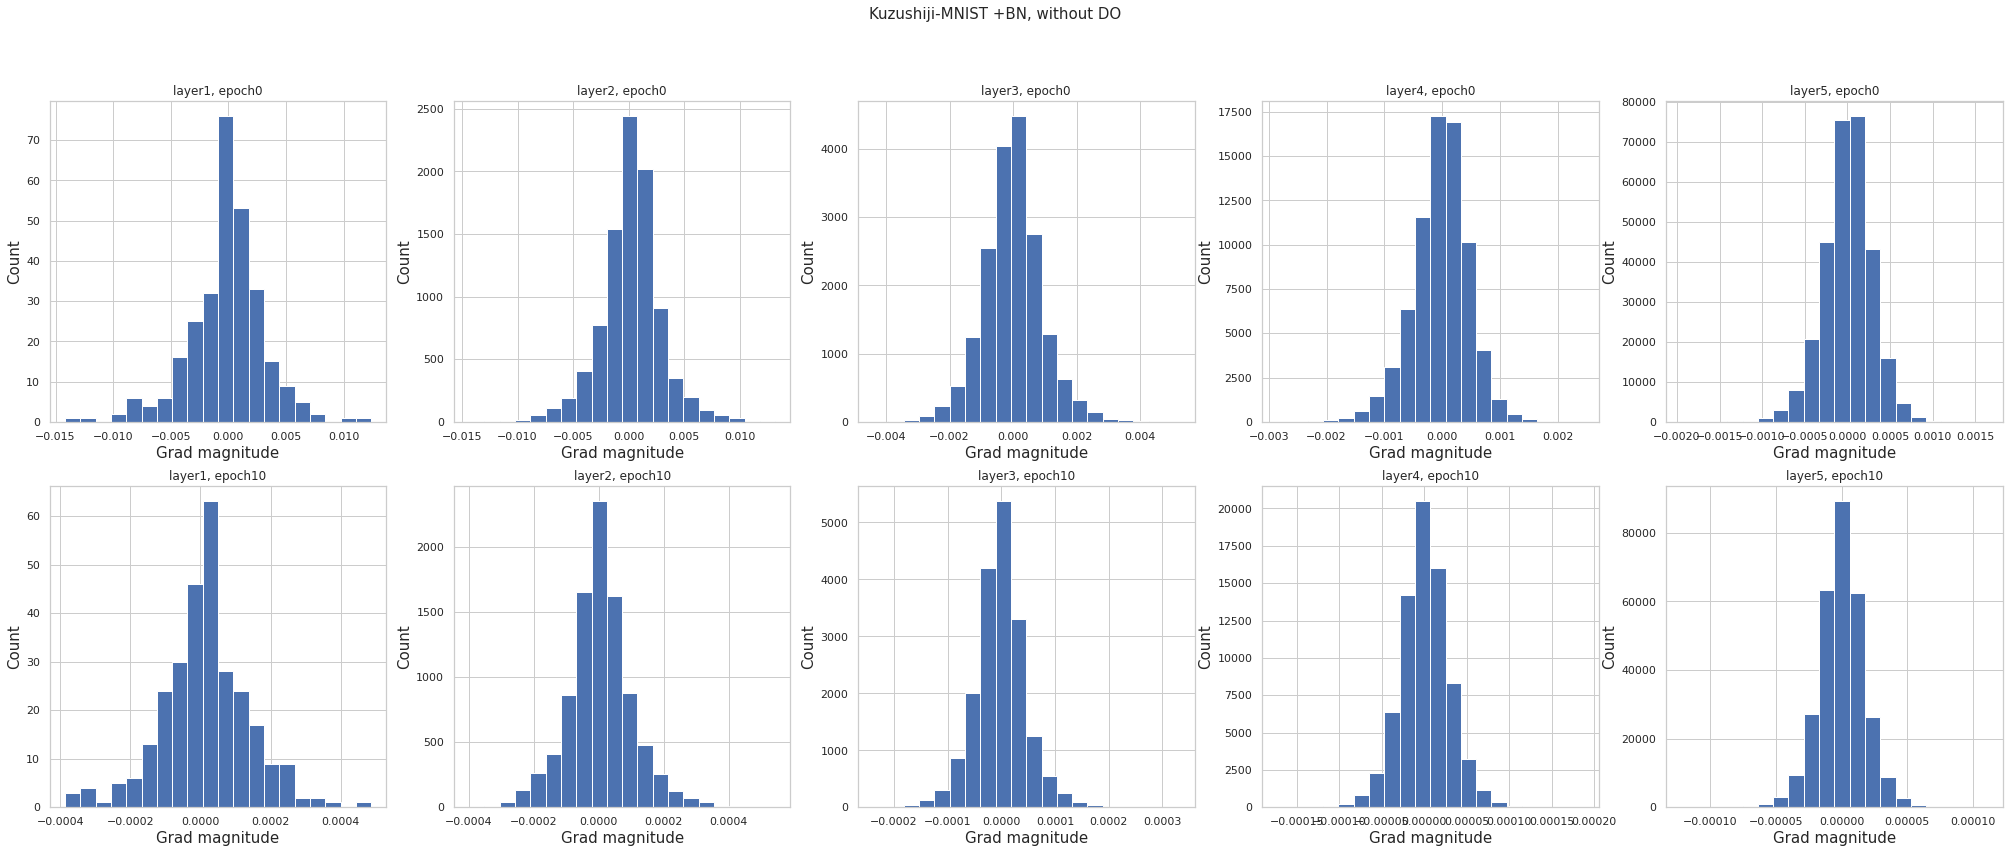

In [20]:
net = ResNet18(use_BN=True, dropout=0, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST +BN, without DO')

In [21]:
accuracy(net, testloader_kmnist)

Test's ac is: 94.700%


Как видно из графиков благодаря нормализации распределение градиентов стало очень сильно похоже на нормальное, с большим пиком в нуле. Так же на некоторых слоях оно стало чуть шире, чем было в прошлом эксперименте. Видно, что на MNIST и Kuzushiji-MNIST на 10 эпохе градиенты на порядок меньше, чем на 1. Это связано с тем, что сеть хорошо обучилась и на последних эпохах мы находимся в окрестности минимума функции потерь, поэтому нужно делать шаги намного меньше

##DO

Исследуем зависимость от Dropout.

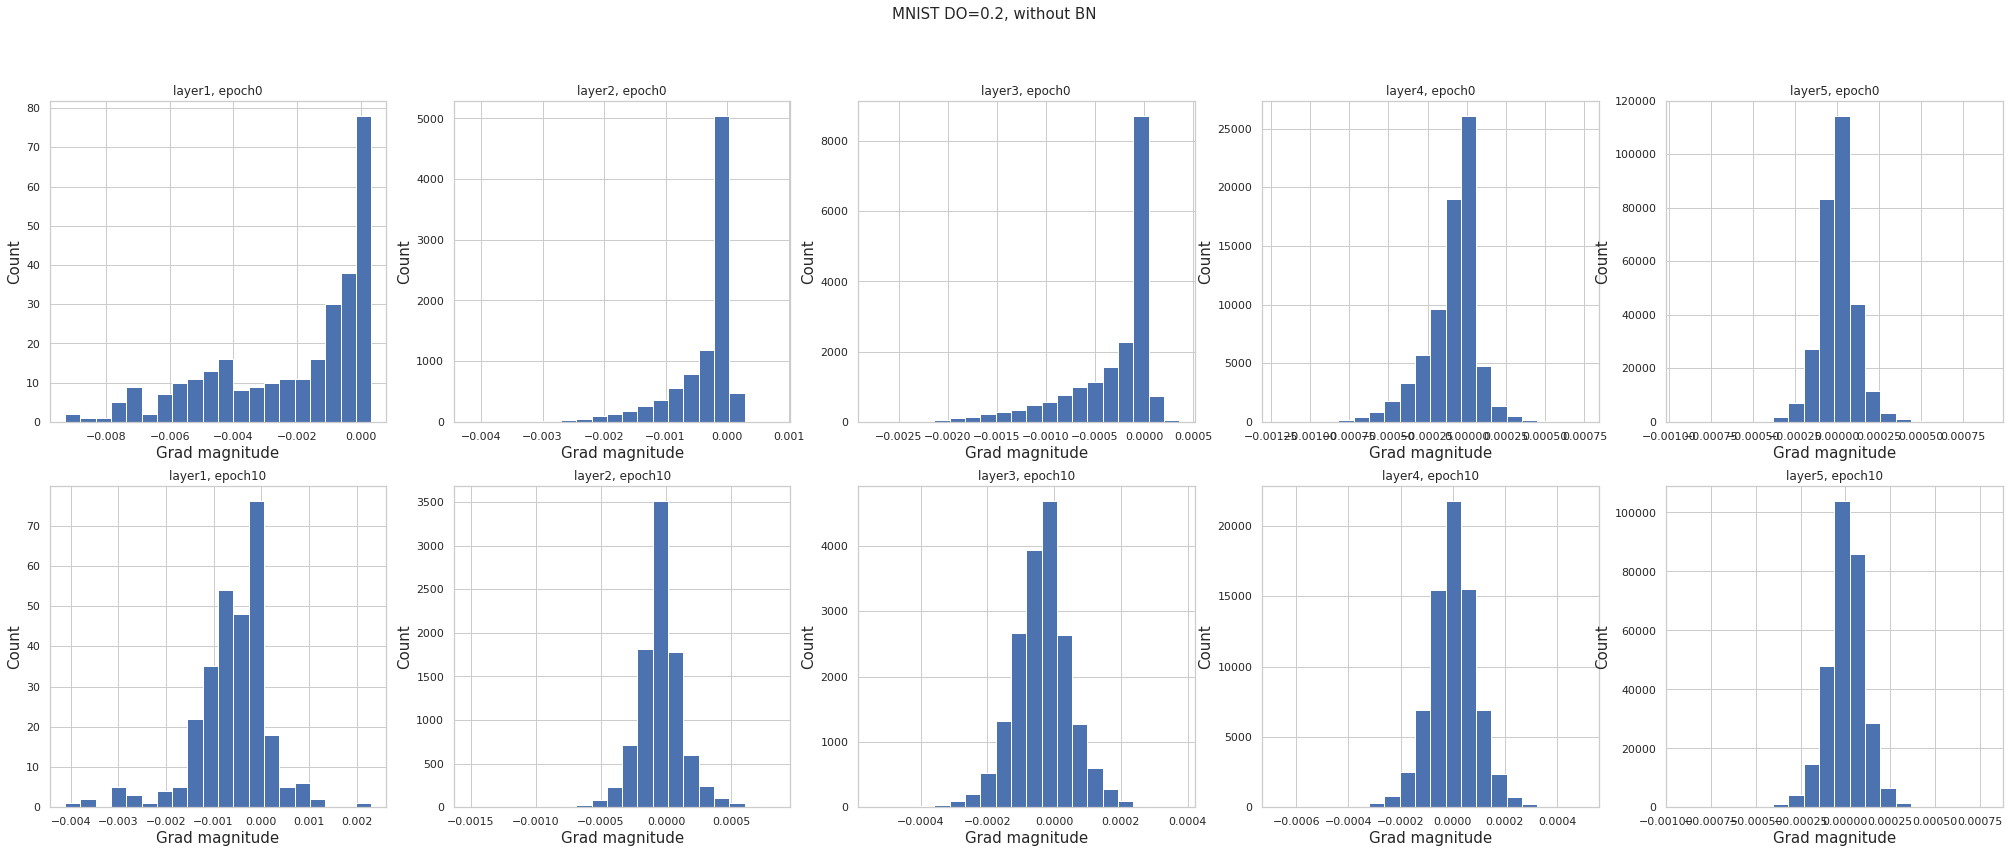

In [24]:
net = ResNet18(use_BN=False, dropout=0.2, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST DO=0.2, without BN')

In [25]:
accuracy(net, testloader_mnist)

Test's ac is: 95.550%


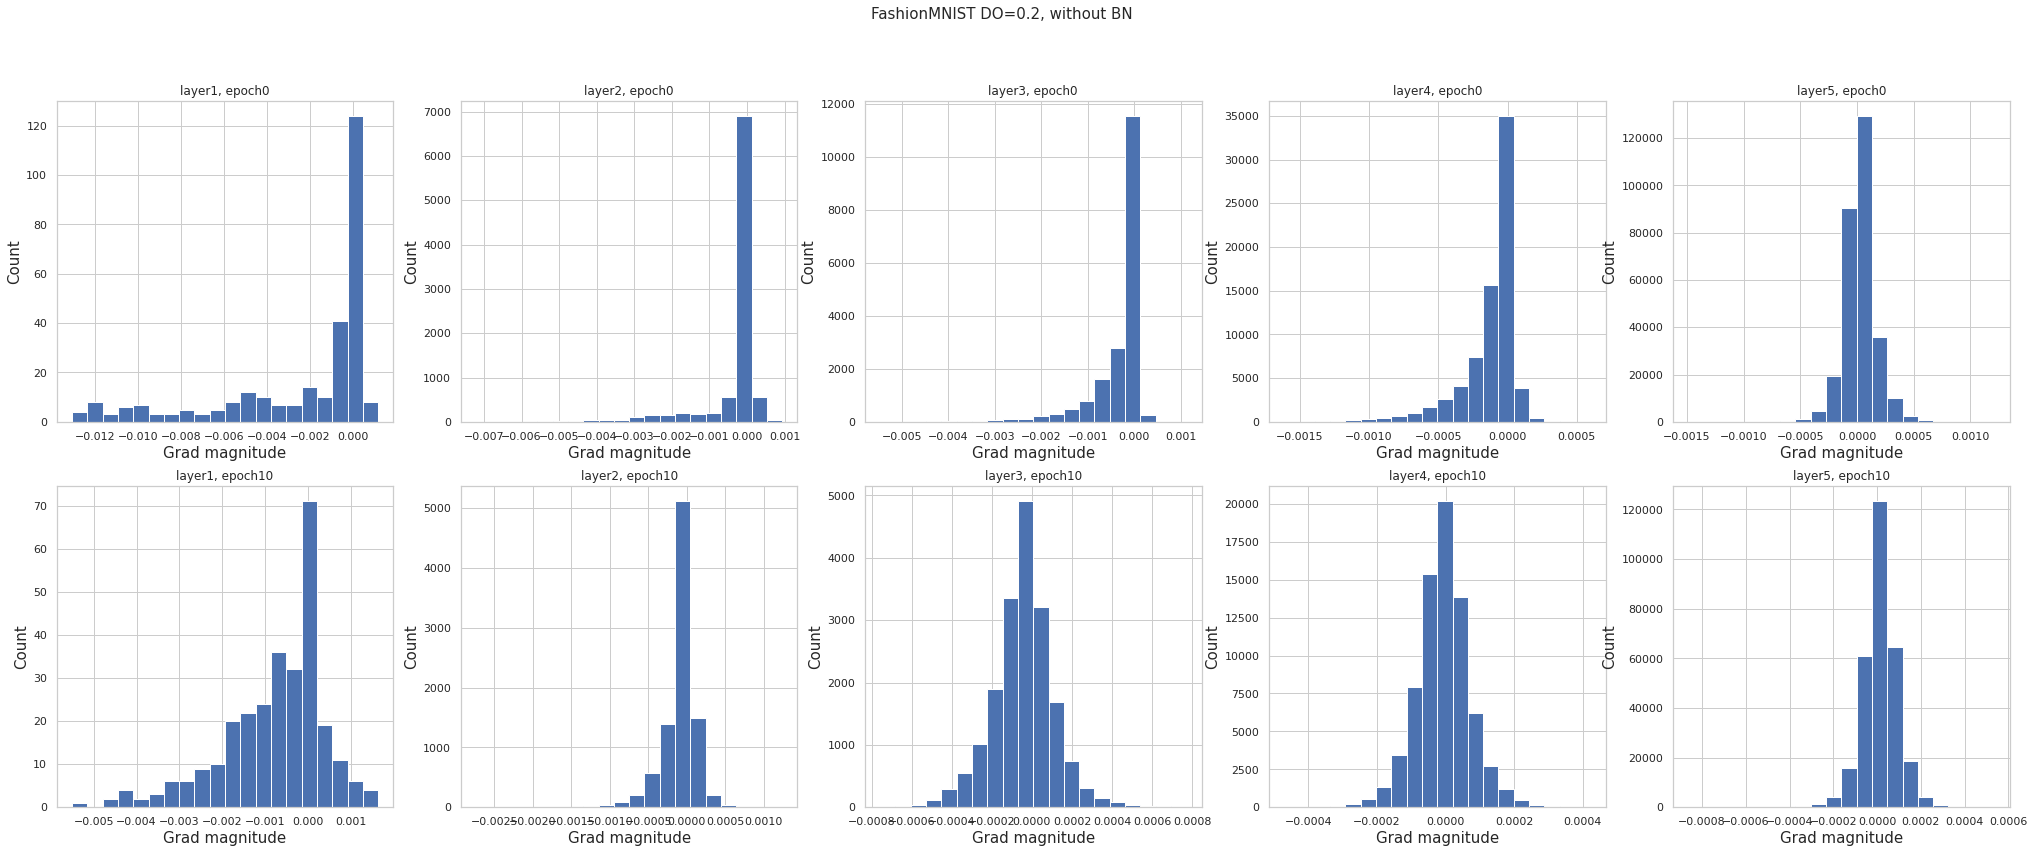

In [26]:
net = ResNet18(use_BN=False, dropout=0.2, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST DO=0.2, without BN')

In [27]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 69.690%


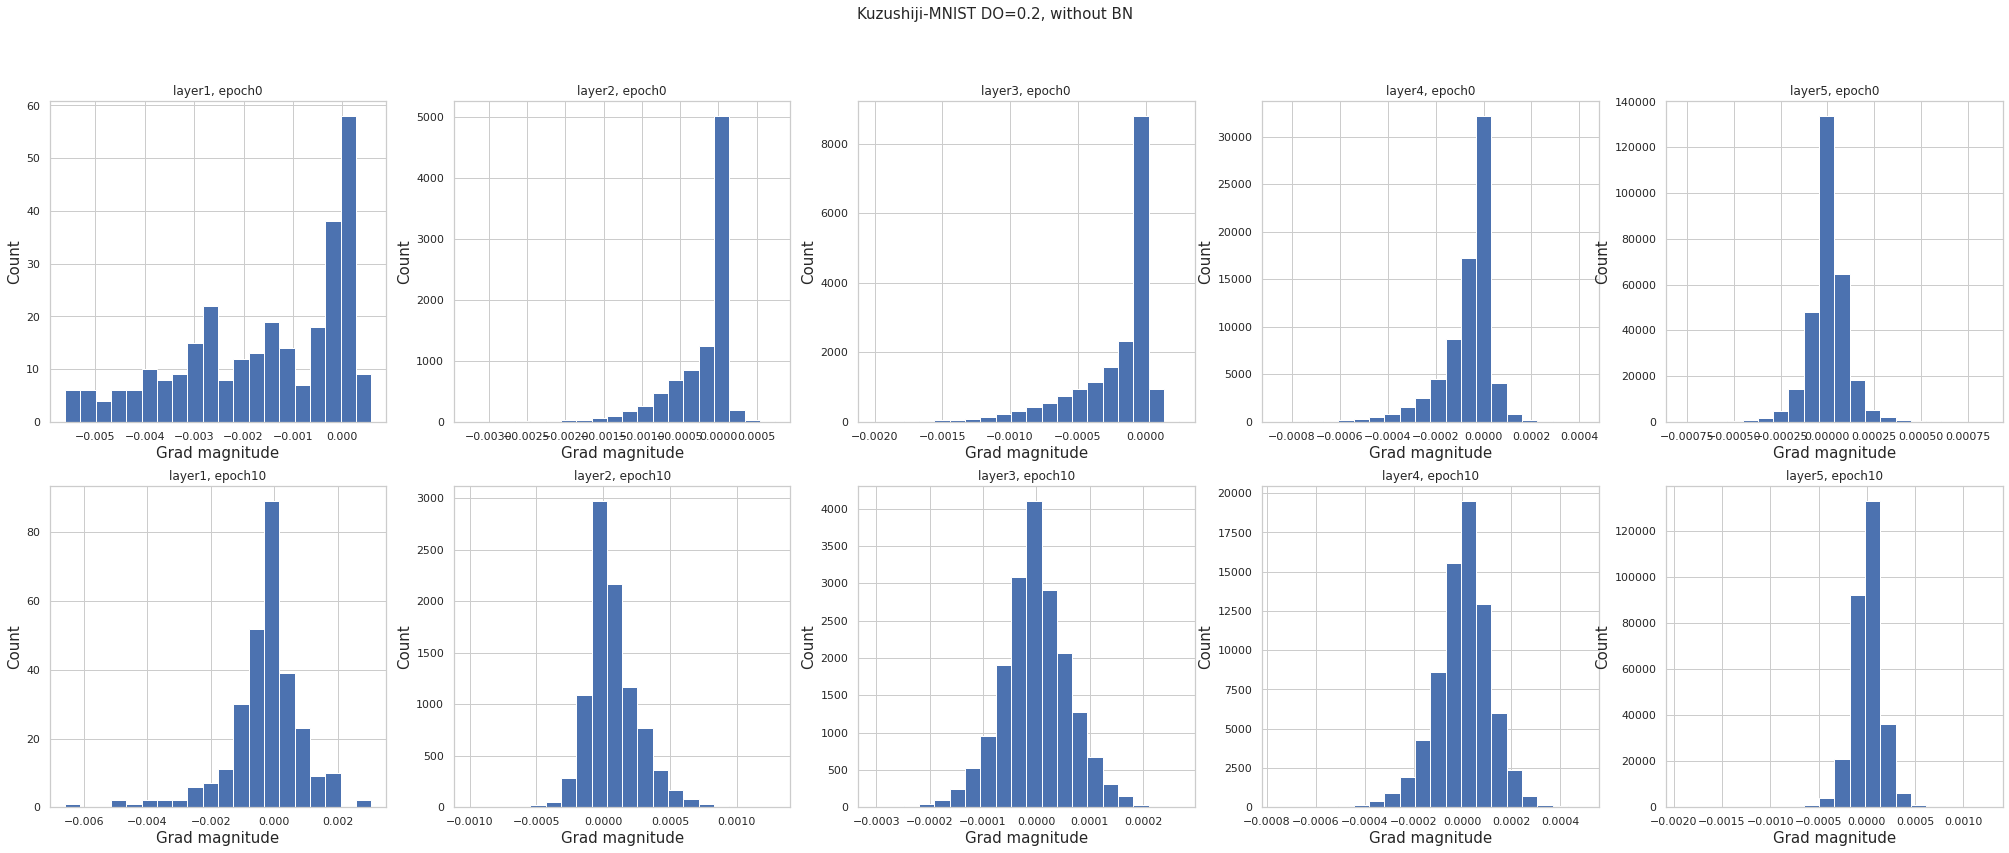

In [28]:
net = ResNet18(use_BN=False, dropout=0.2, skip=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST DO=0.2, without BN')

In [29]:
accuracy(net, testloader_kmnist)

Test's ac is: 80.280%


Получим примерно такие же результаты, как и во втором эксперименте. Графики практически идентичны тем, что мы получали ранее. Заметим, что в среднем градиенты стали чуть меньше. Скорее всего это связано с техникой Dropout, который зануляет некоторые нейроны.

##Ширина

Увеличим ширину сети в 2 раза (количество каналов в каждом свёрточном слое). При этом будем использовать батч нормализацию без дропаута.

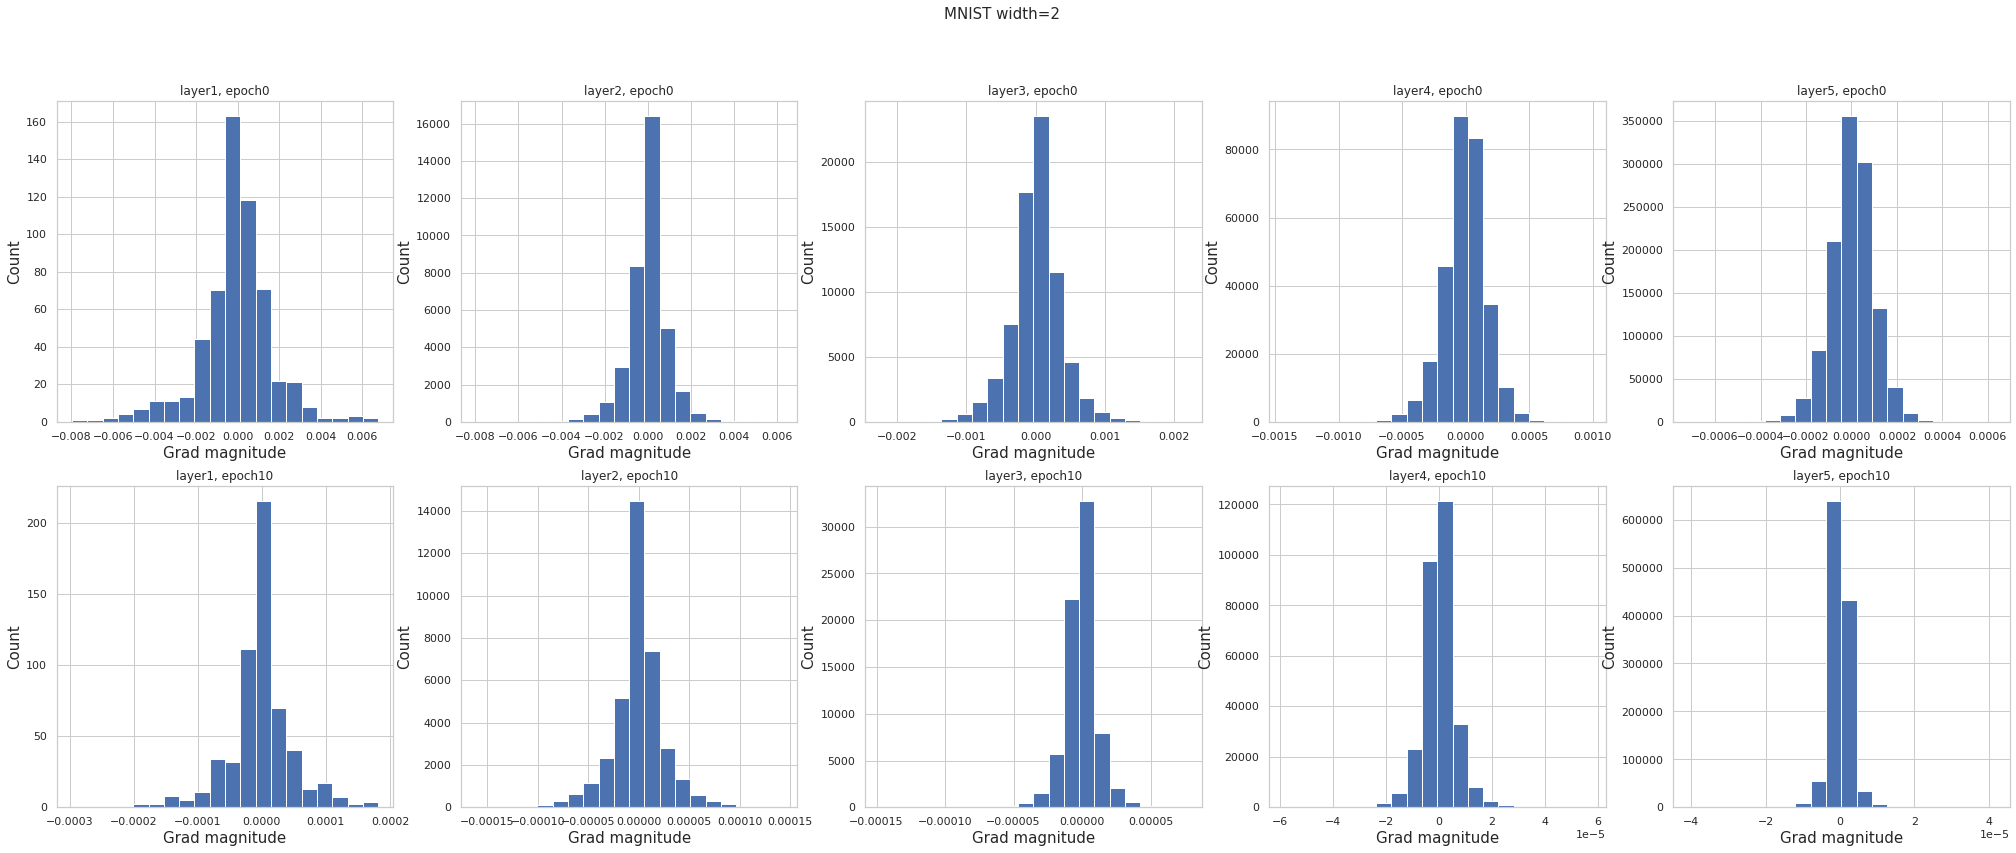

In [30]:
net = ResNet18(width=2).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST width=2')

In [31]:
accuracy(net, testloader_mnist)

Test's ac is: 99.030%


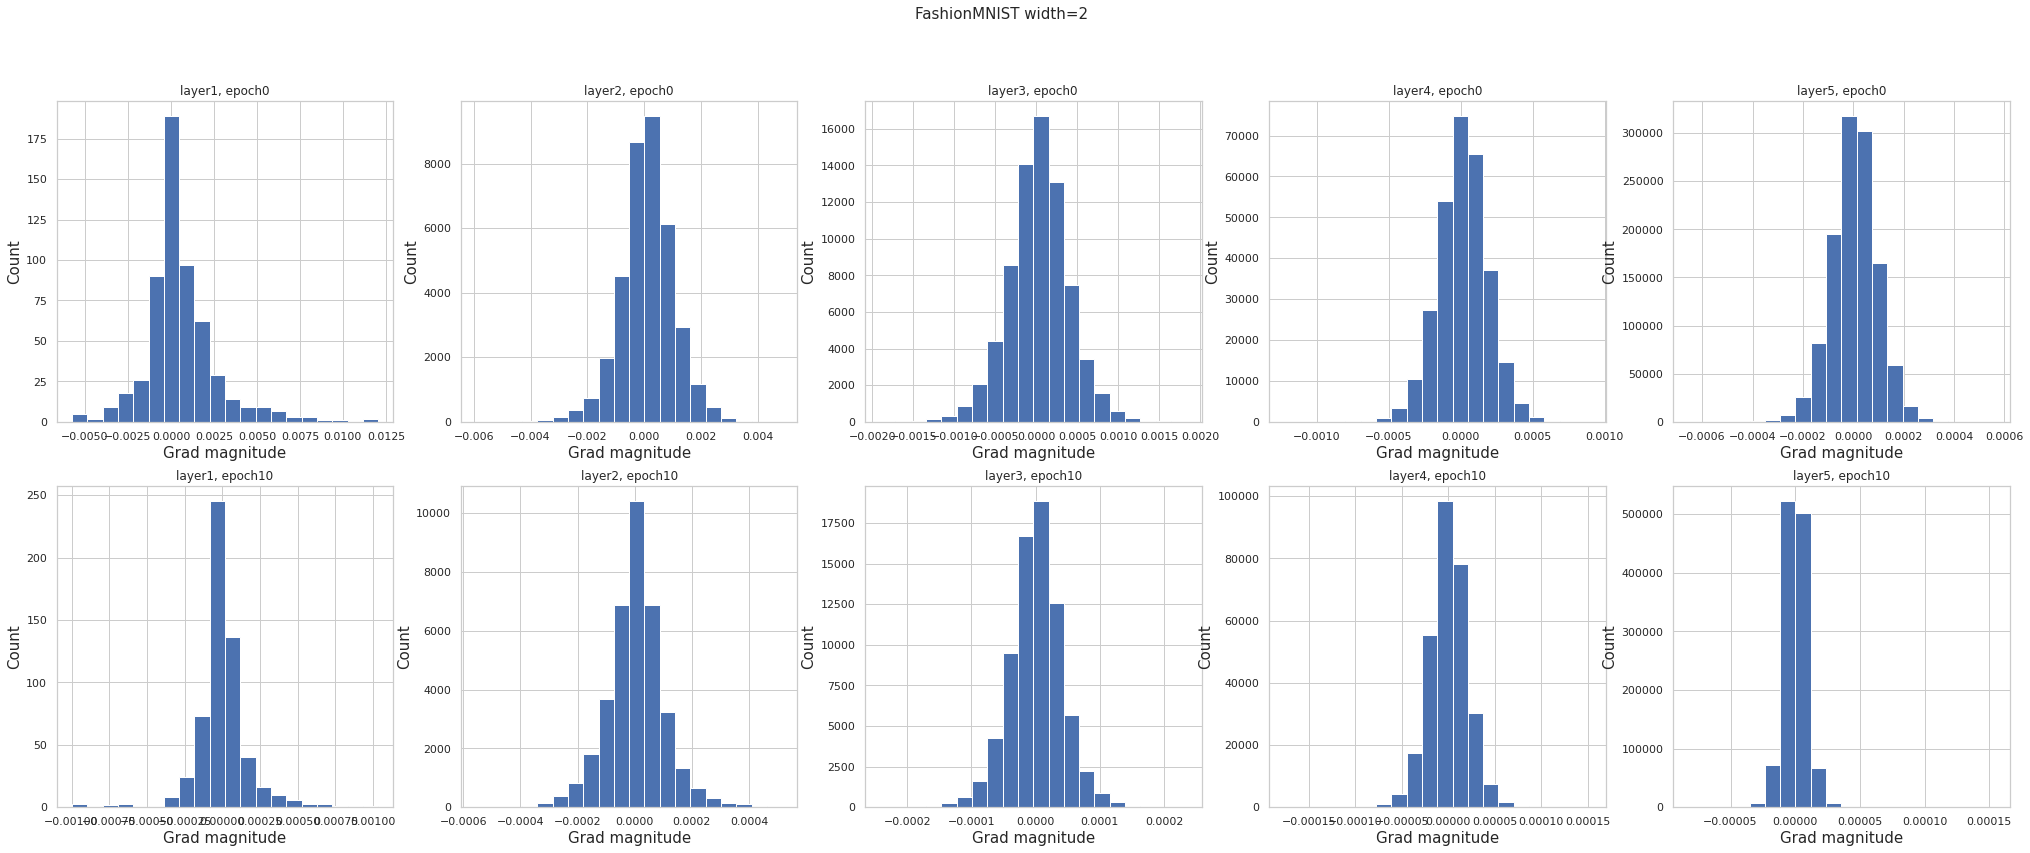

In [32]:
net = ResNet18(width=2).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST width=2')

In [33]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 90.110%


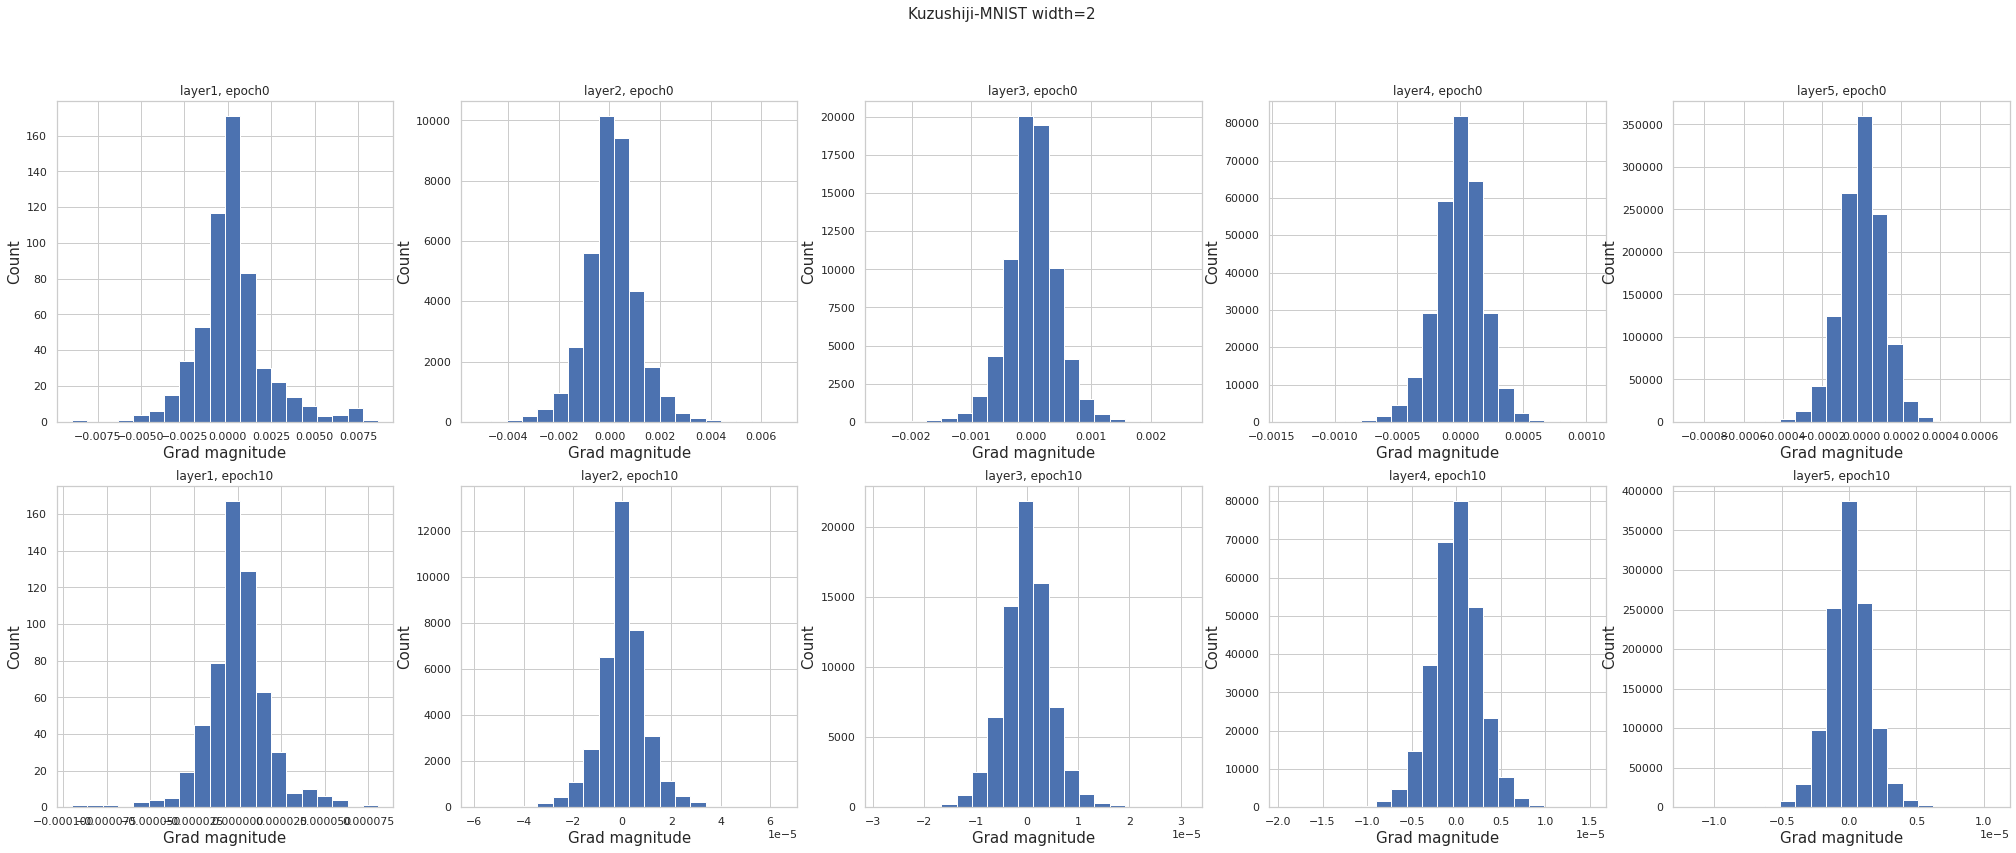

In [34]:
net = ResNet18(width=2).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST width=2')

In [35]:
accuracy(net, testloader_kmnist)

Test's ac is: 94.580%


Значительной разницы в распределении между широкой и узкой архитектурами не заметно, кроме того, что градиенты стали чуть меньше (хвосты стали уже, то есть уменьшилась дисперсия в распределении).

##Глубина

Попробуем взять менее глубокую сеть (2 свёрточных слоя в блоке вместо 4).

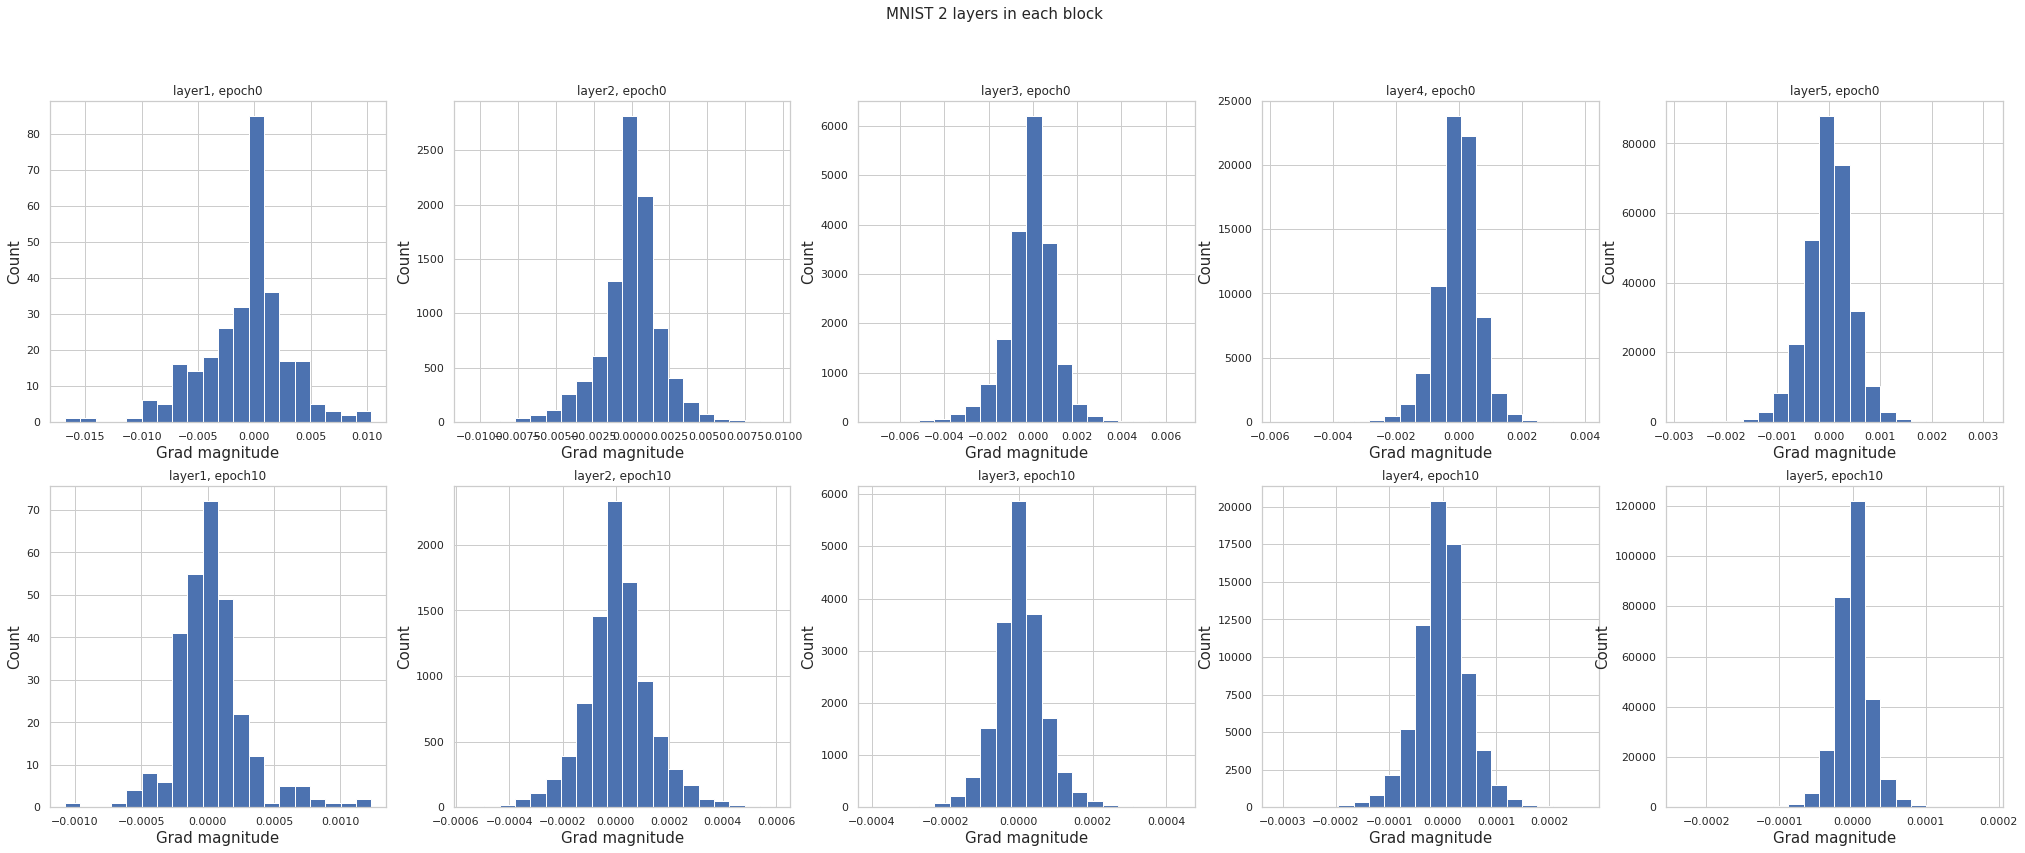

In [16]:
net = ResNet18(depth=1).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST 2 layers in each block')

In [17]:
accuracy(net, testloader_mnist)

Test's ac is: 98.910%


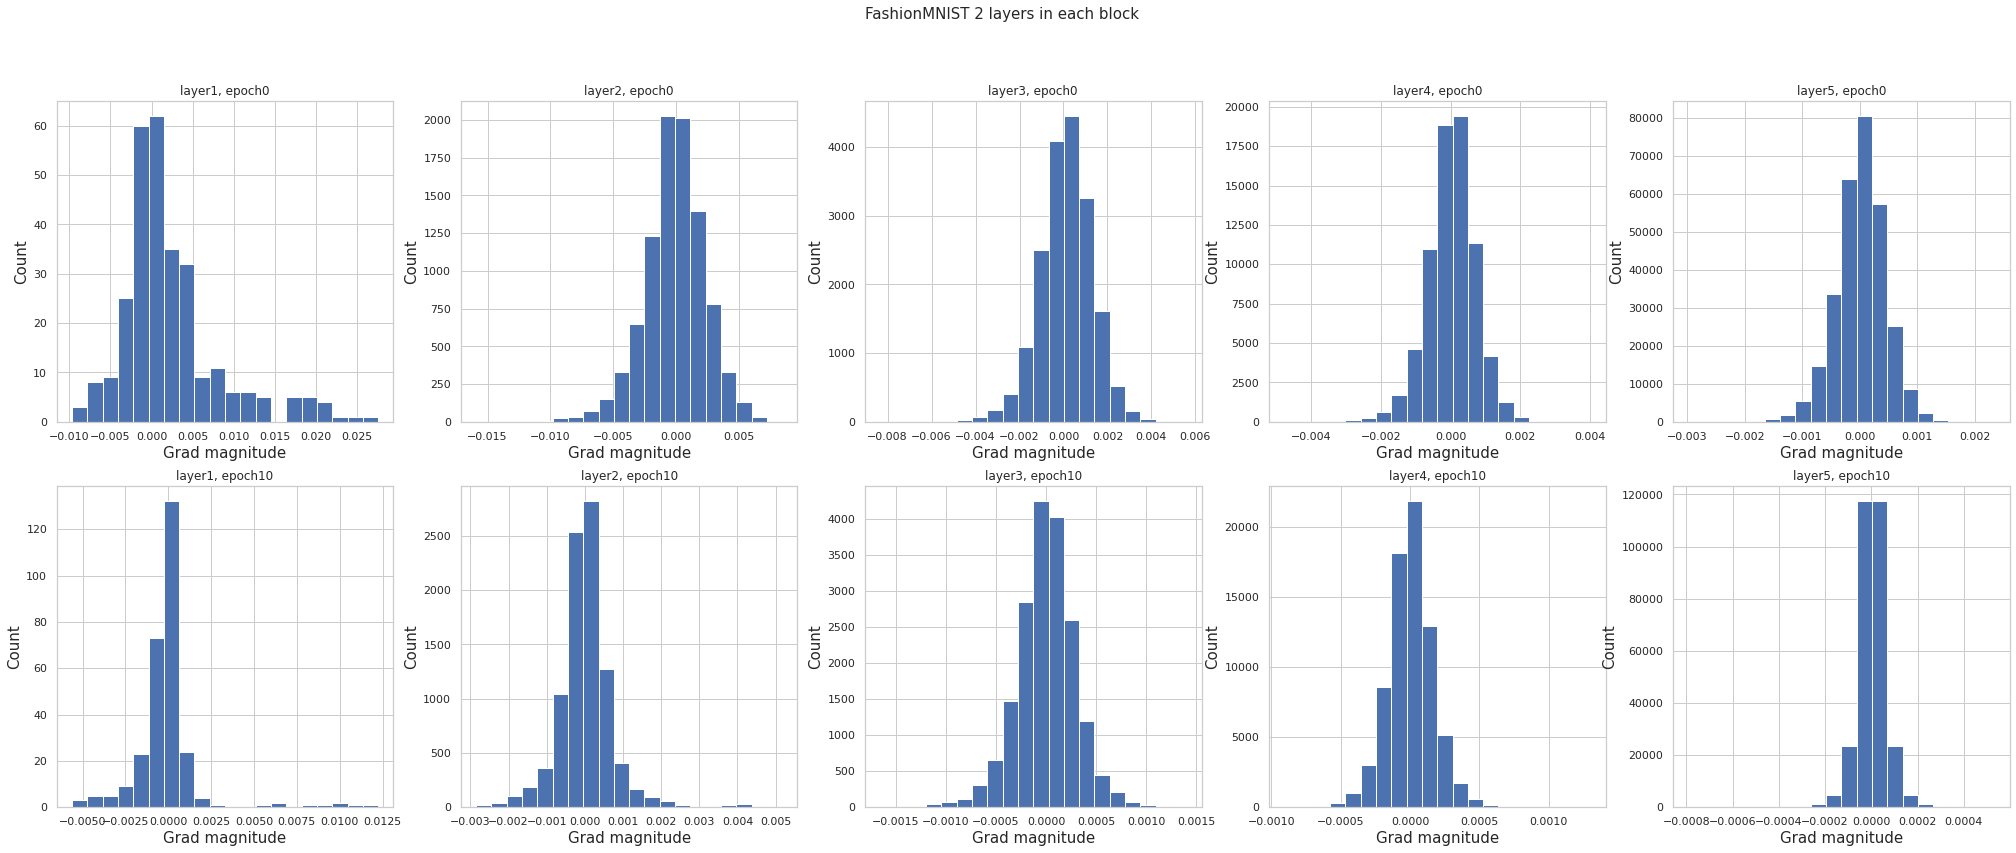

In [18]:
net = ResNet18(depth=1).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST 2 layers in each block')

In [19]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 89.860%


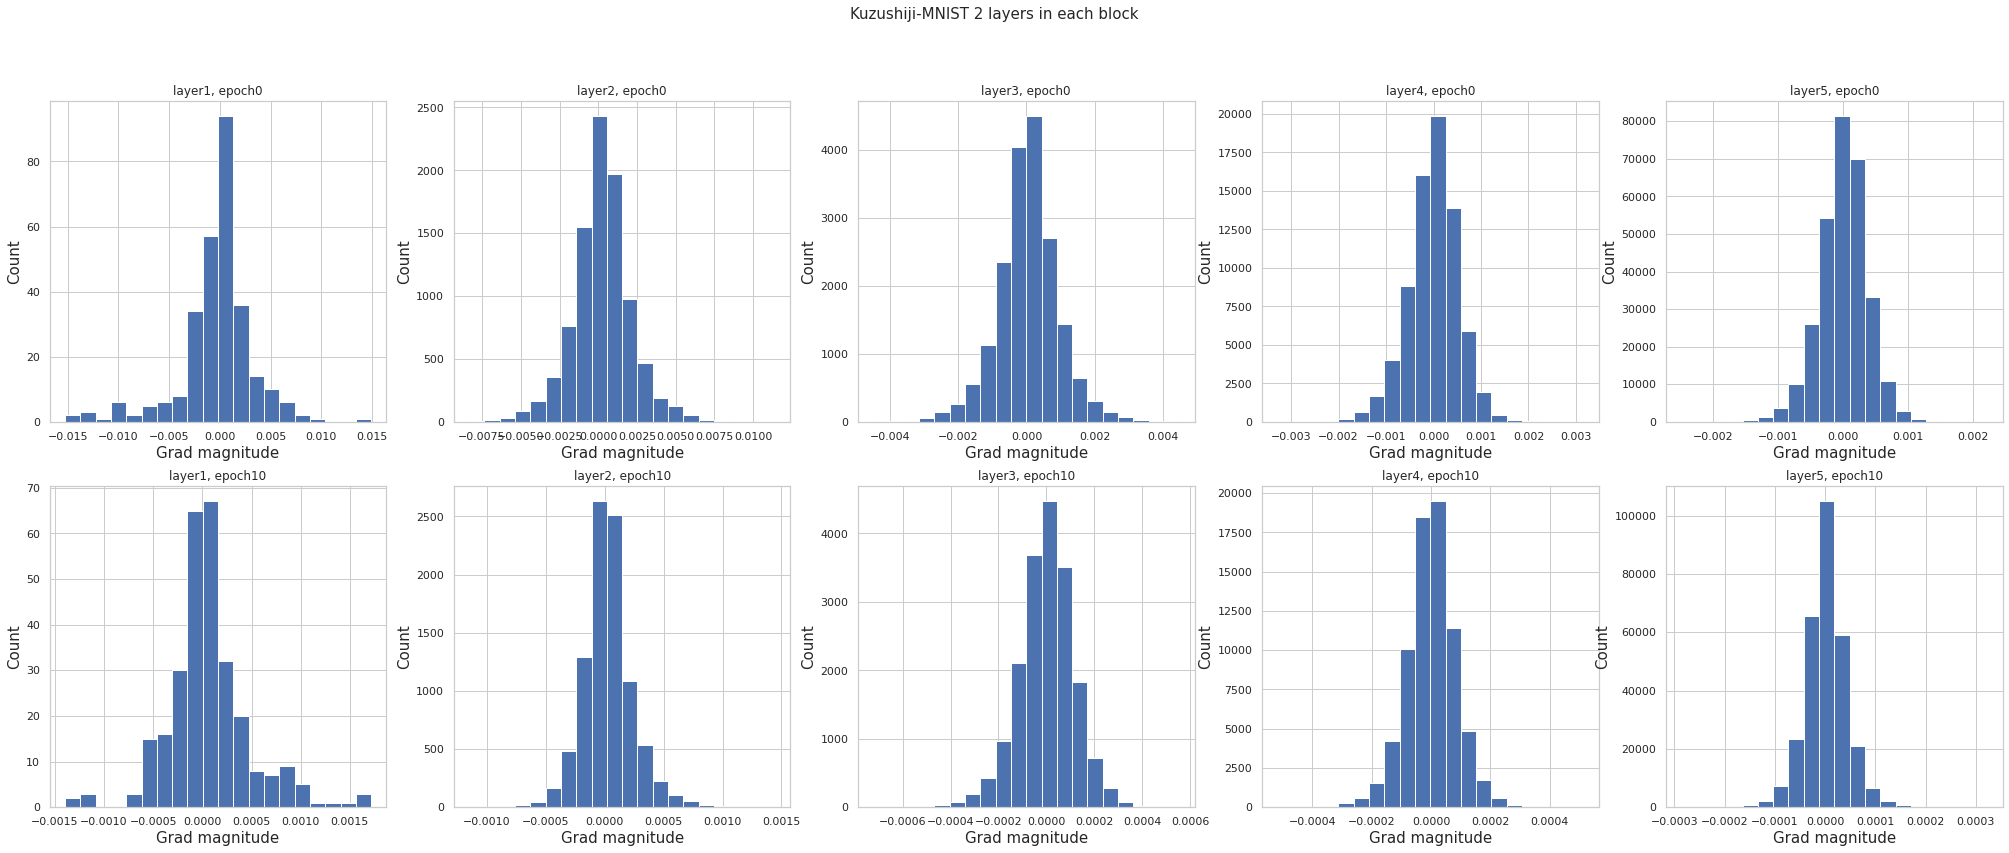

In [20]:
net = ResNet18(depth=1).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST 2 layers in each block')

In [21]:
accuracy(net, testloader_kmnist)

Test's ac is: 92.790%


Видно, что распределения градиентов абсолютно анологичны второму эксперименту.

##Инициализация

Исследуем зависимость распределения градиентов от начальной инциализации весов. Попробуем две стратегии Xavier и Kaiming. Для ускорения времени обучения возьмём менее глубокую сеть.

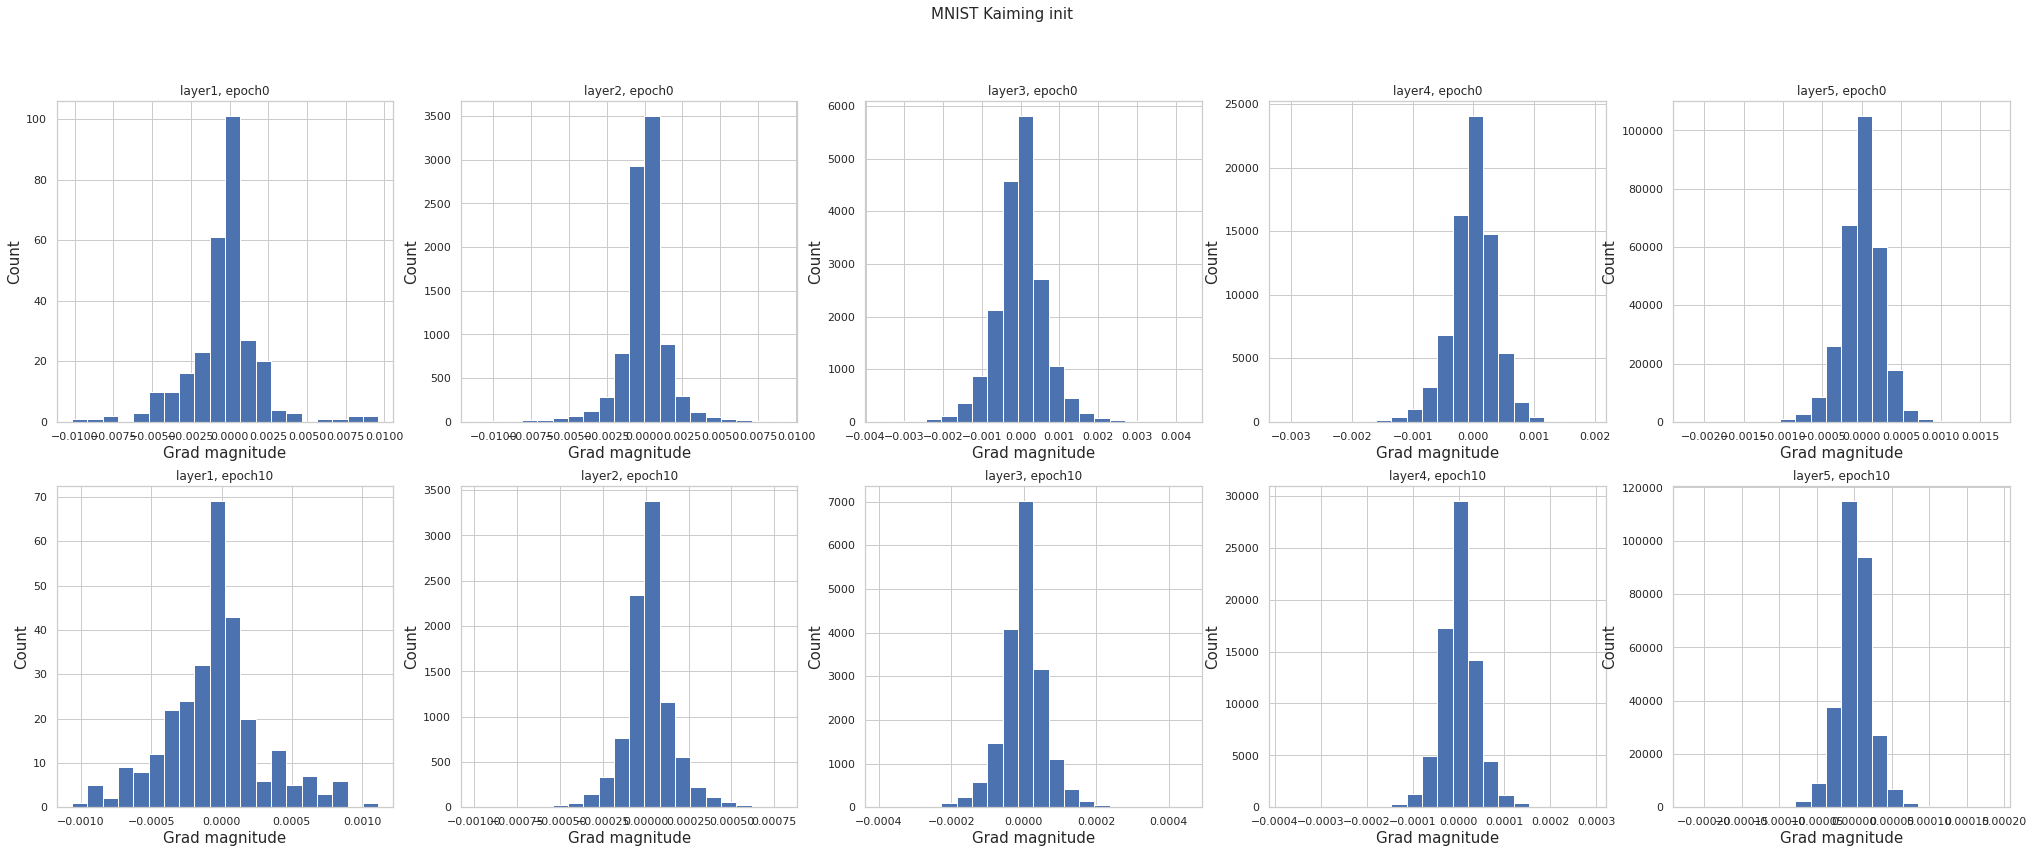

In [23]:
net = ResNet18(depth=1, init='kaiming').to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST Kaiming init')

In [24]:
accuracy(net, testloader_mnist)

Test's ac is: 98.020%


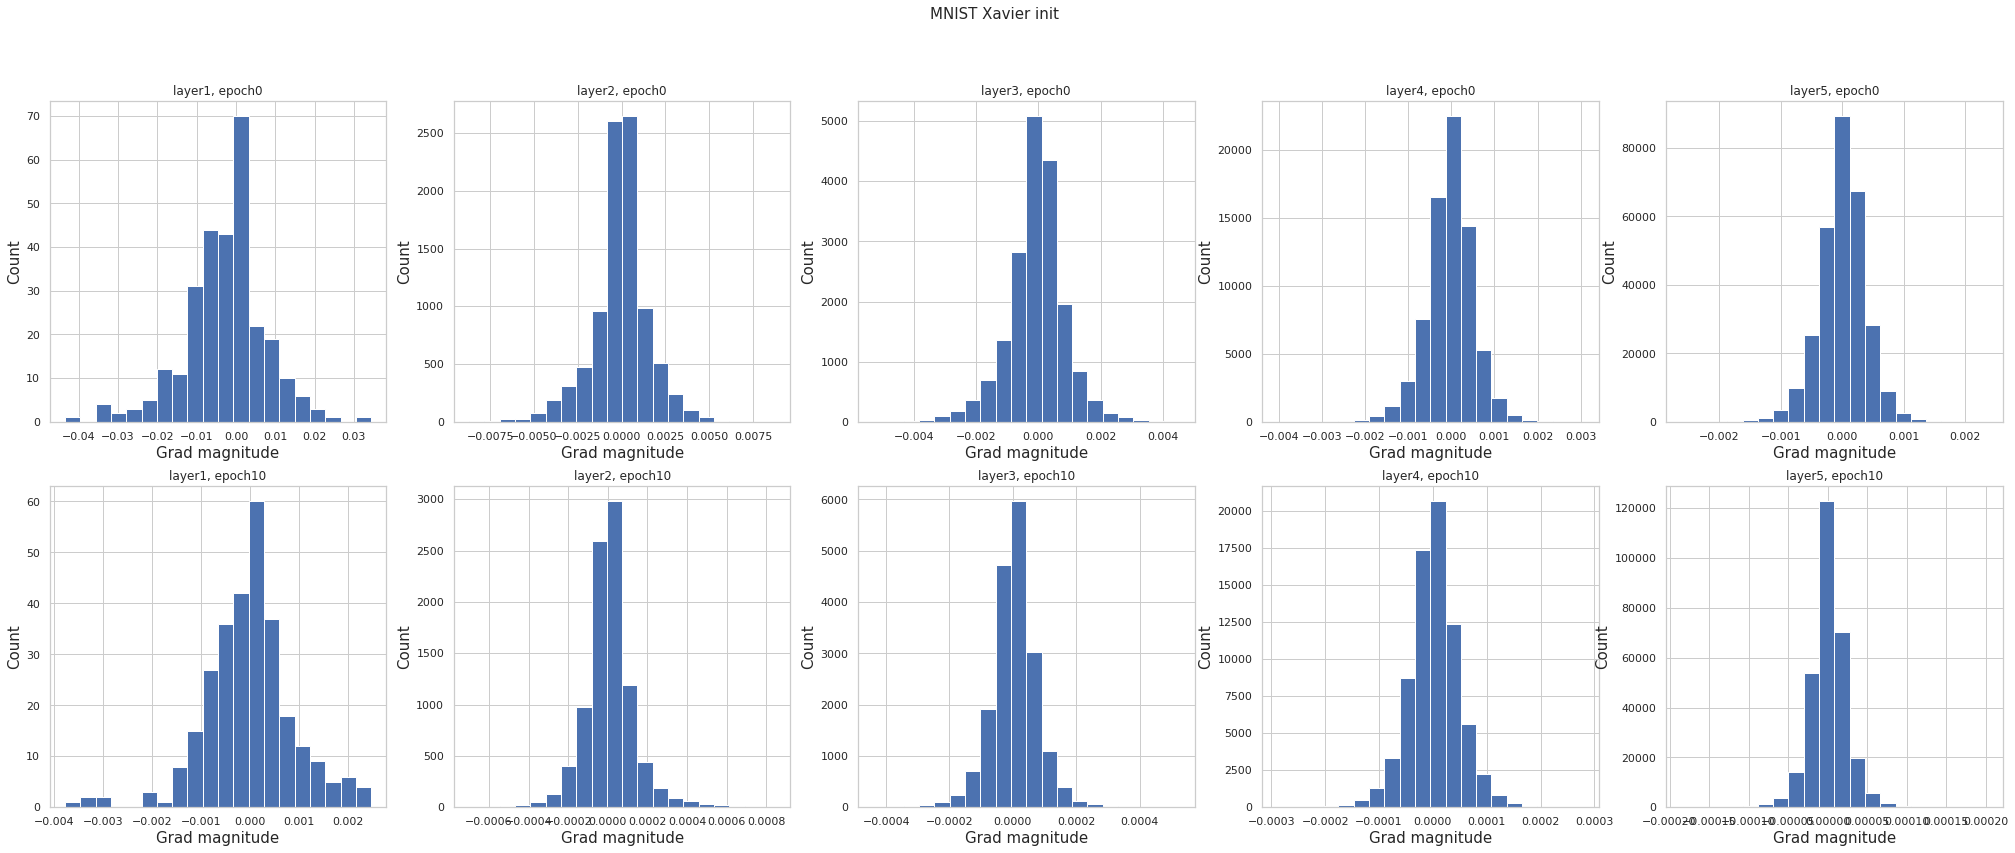

In [25]:
net = ResNet18(depth=1, init='xavier').to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST Xavier init')

In [26]:
accuracy(net, testloader_mnist)

Test's ac is: 98.770%


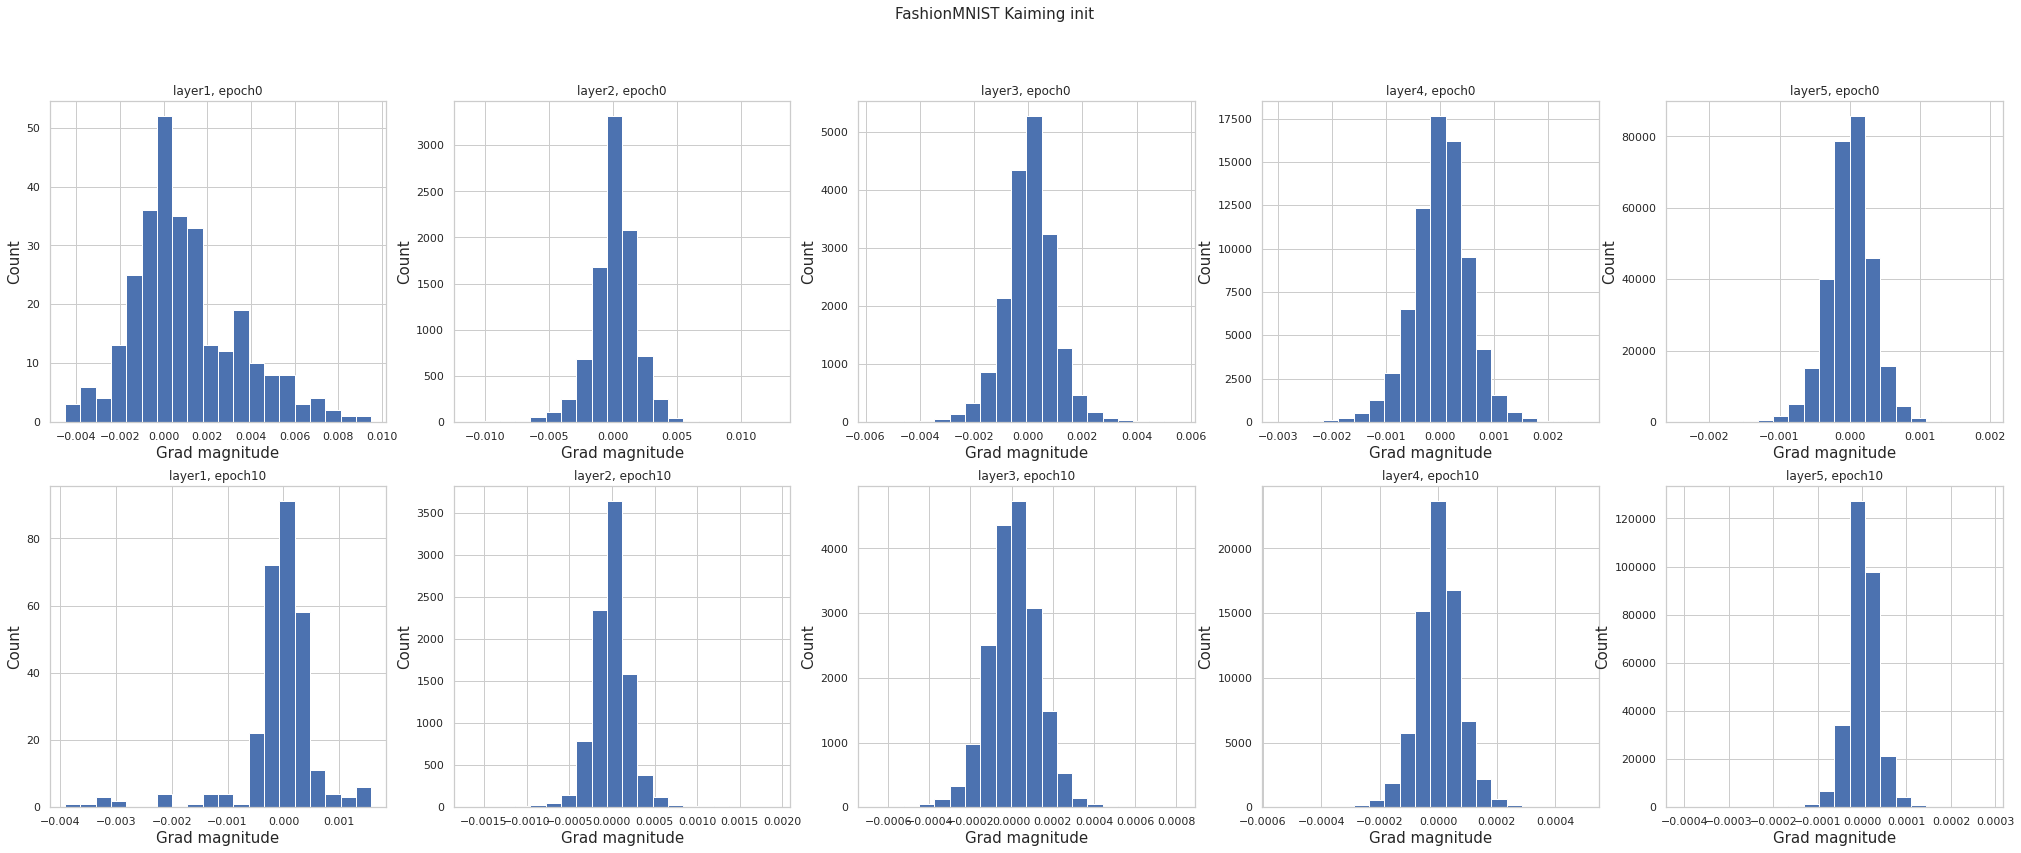

In [27]:
net = ResNet18(depth=1, init='kaiming').to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST Kaiming init')

In [28]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 87.630%


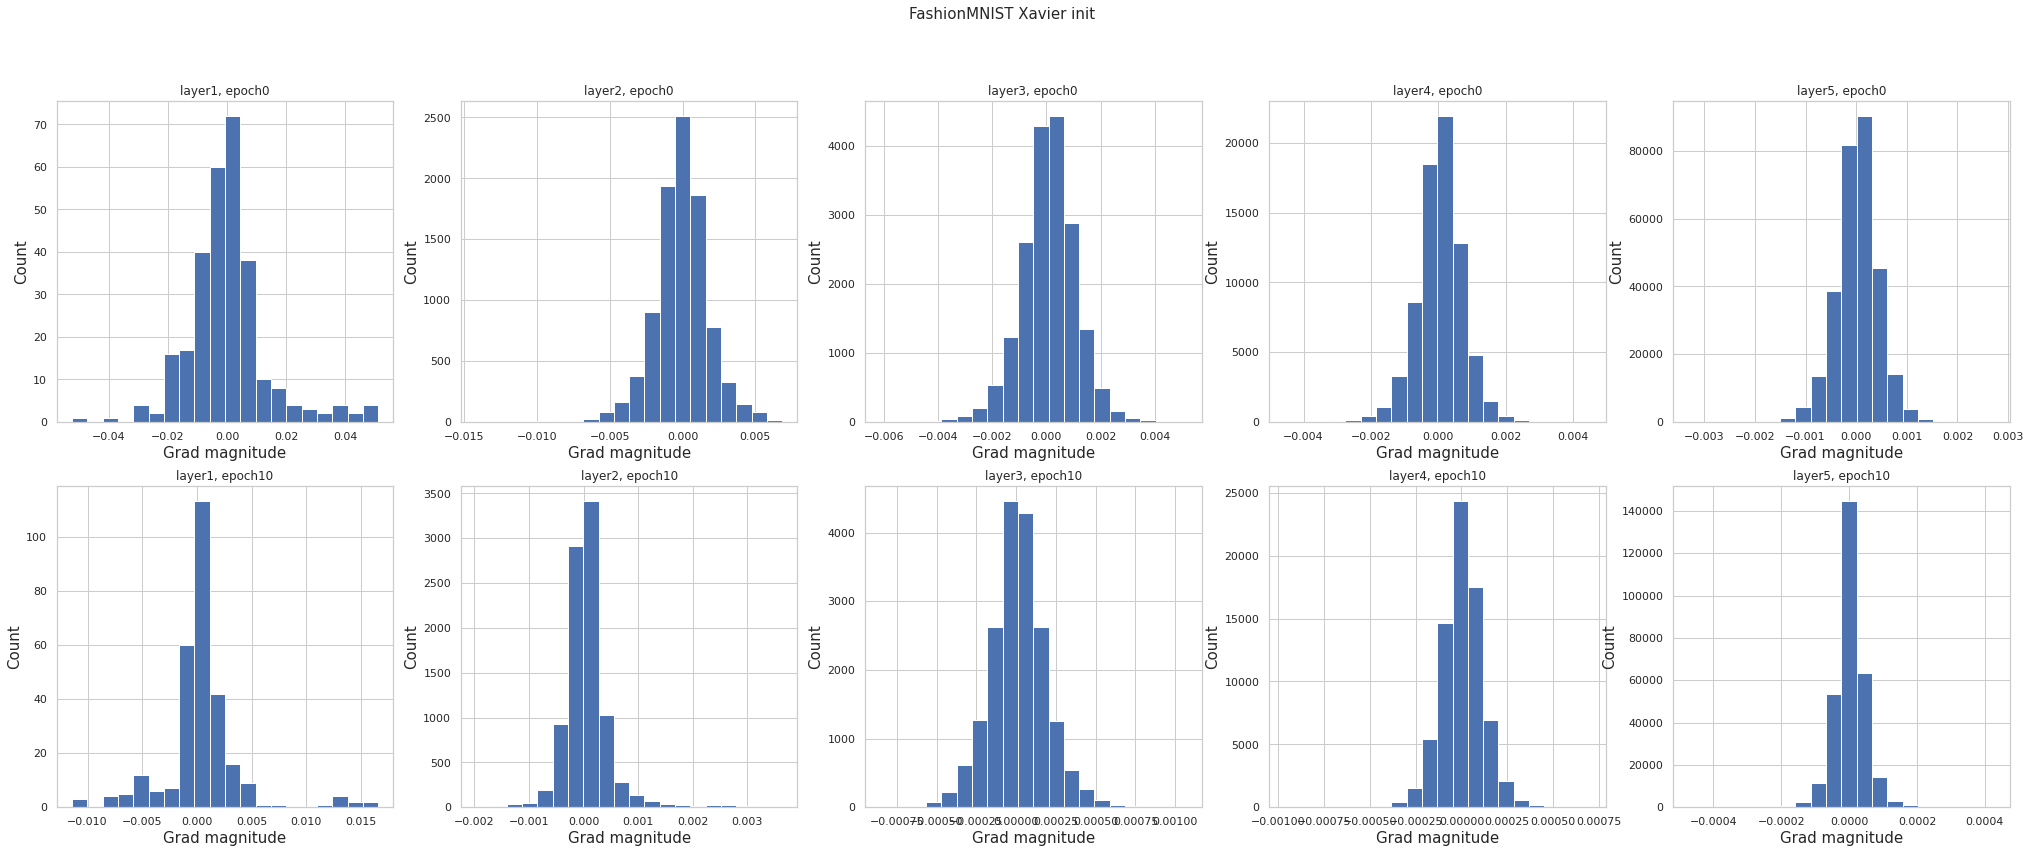

In [29]:
net = ResNet18(depth=1, init='xavier').to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST Xavier init')

In [30]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 89.430%


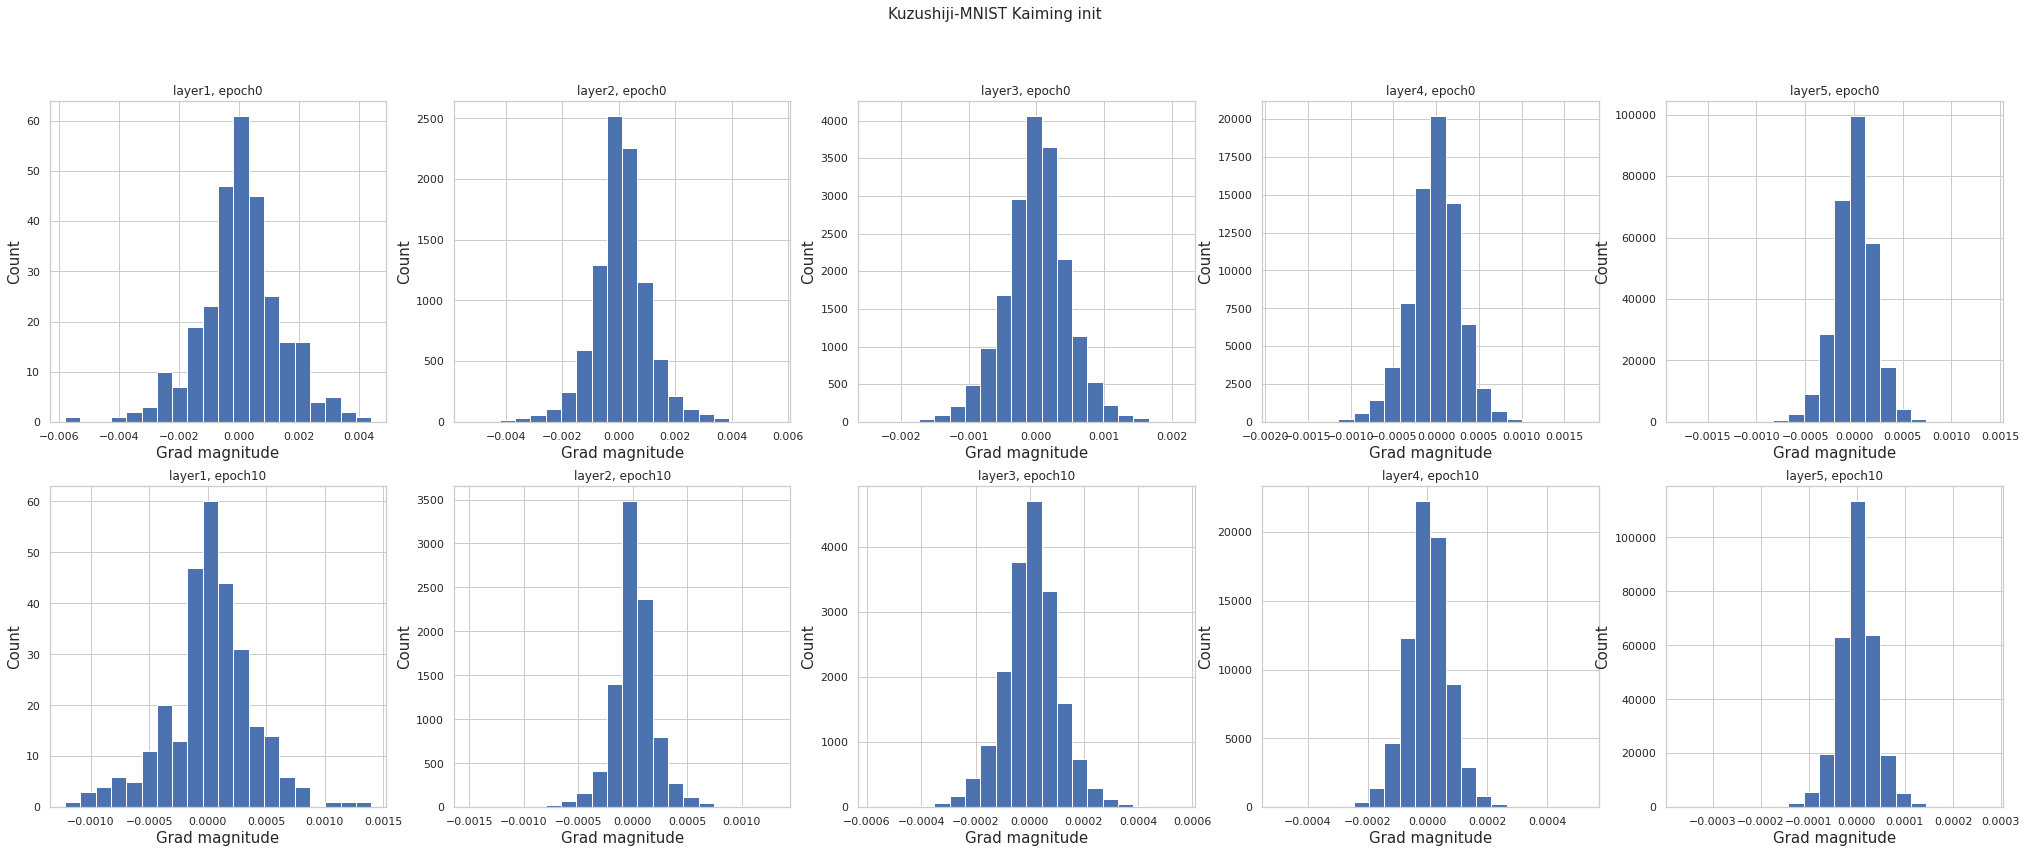

In [31]:
net = ResNet18(depth=1, init='kaiming').to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST Kaiming init')

In [32]:
accuracy(net, testloader_kmnist)

Test's ac is: 87.340%


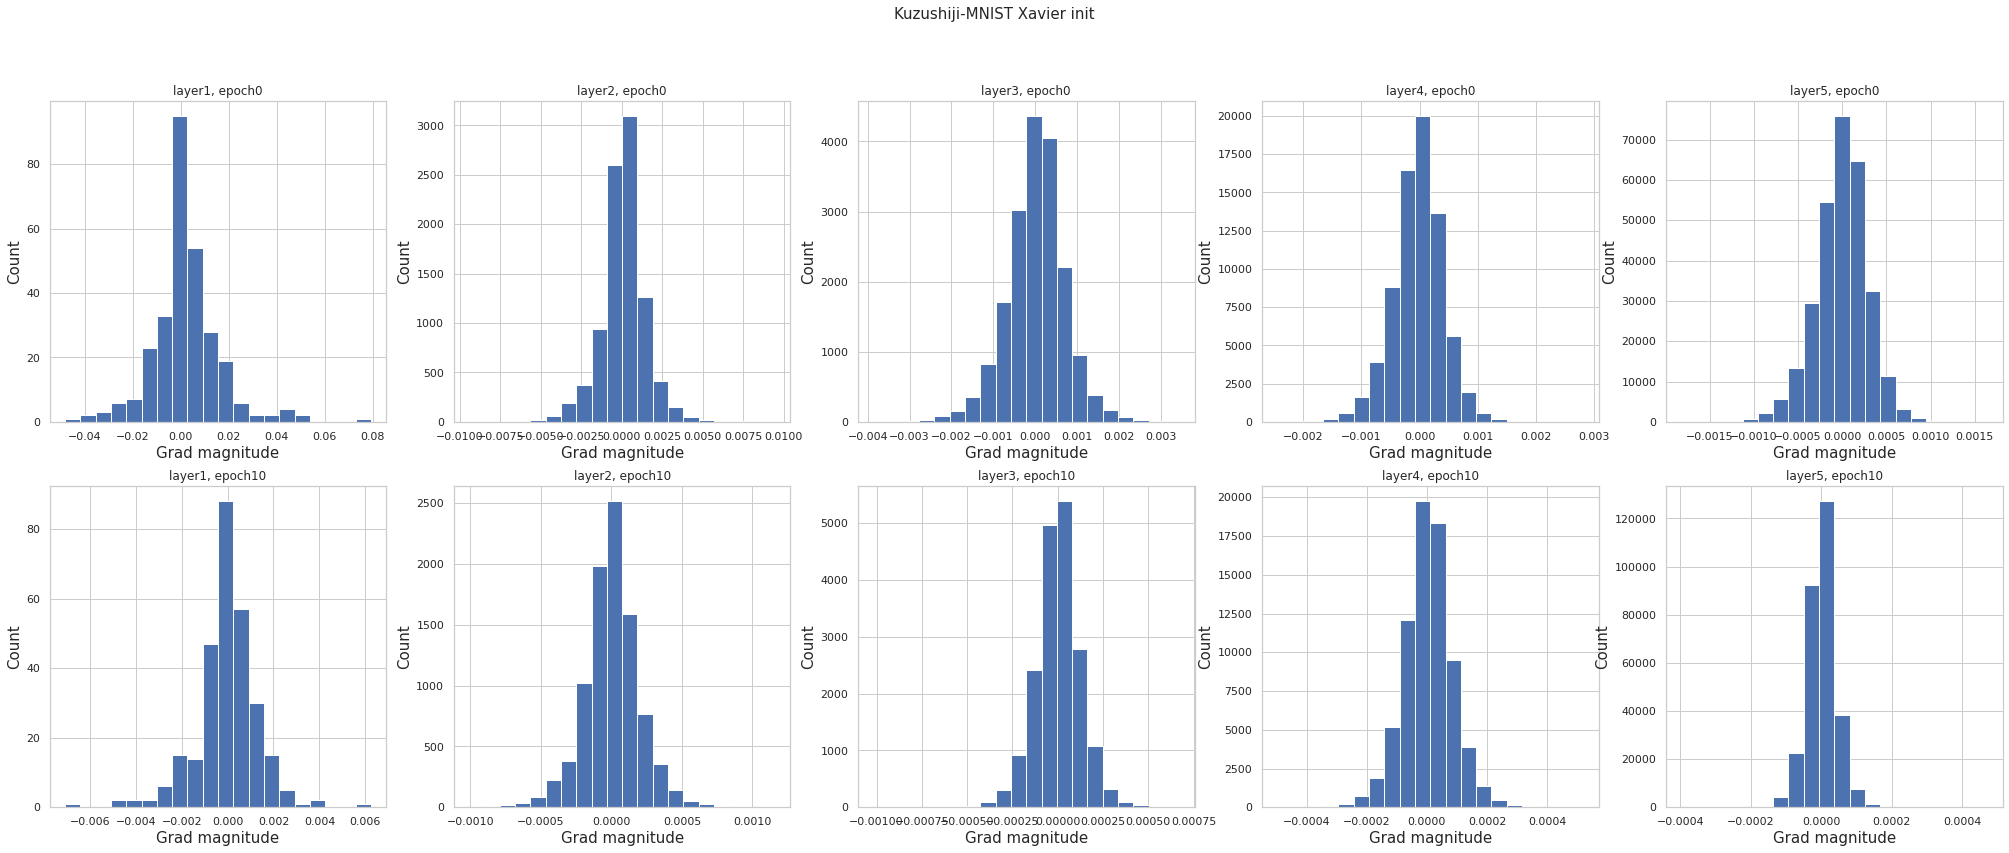

In [33]:
net = ResNet18(depth=1, init='xavier').to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST Xavier init')

In [34]:
accuracy(net, testloader_kmnist)

Test's ac is: 90.790%


Можно заметить, что для MNIST и FashionMNIST Kaiming имеет примерно такое же распределение, как и при дефолтной инициализации. Распределение при инициализации методом Xavier даёт чуть более широкие хвосты. Для Kuzushiji-MNIST видно, что Kaiming даёт довольно более узкое распределение, а Xavier так же чуть шире. Заметим, что для этого датасета на последних эпохах градиенты уменьшаются не так значительно, как было ранее, что говорит о том, что сеть недоучилась. Это же видно и из качества на тесте.

##Оптимизатор

Попробуем взять другой оптимизатор. Обучим сеть с SGD.

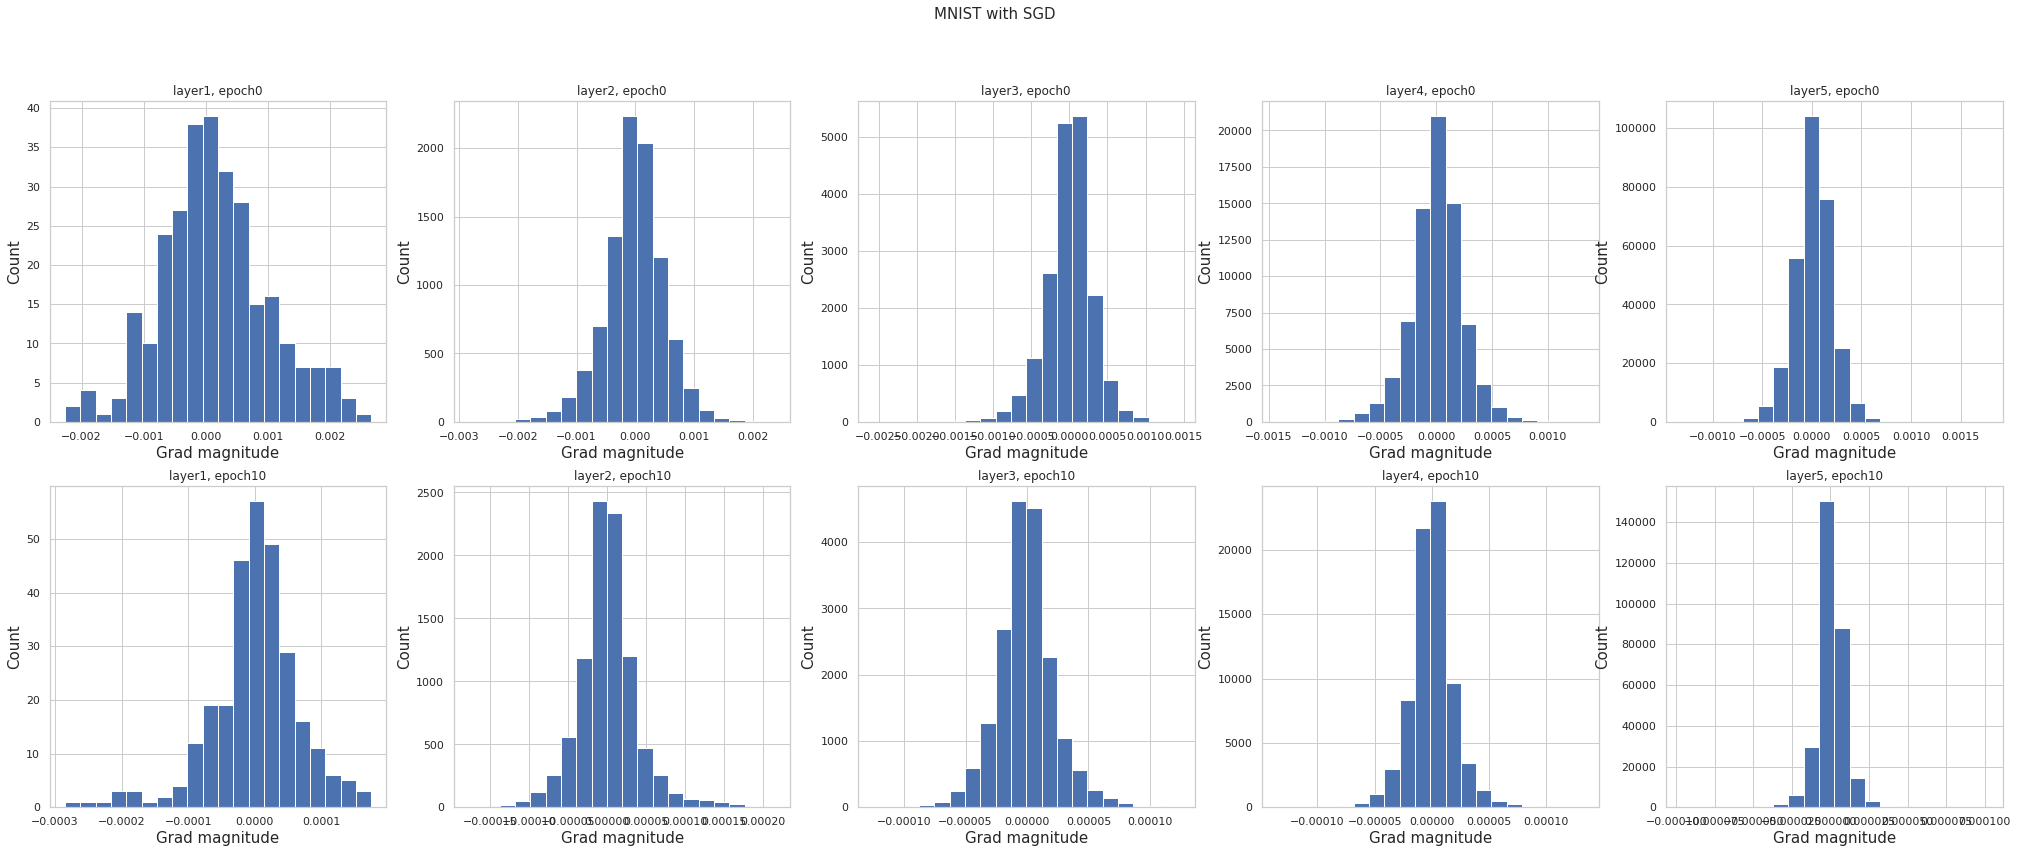

In [35]:
net = ResNet18(depth=1).to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST with SGD')

In [36]:
accuracy(net, testloader_mnist)

Test's ac is: 99.270%


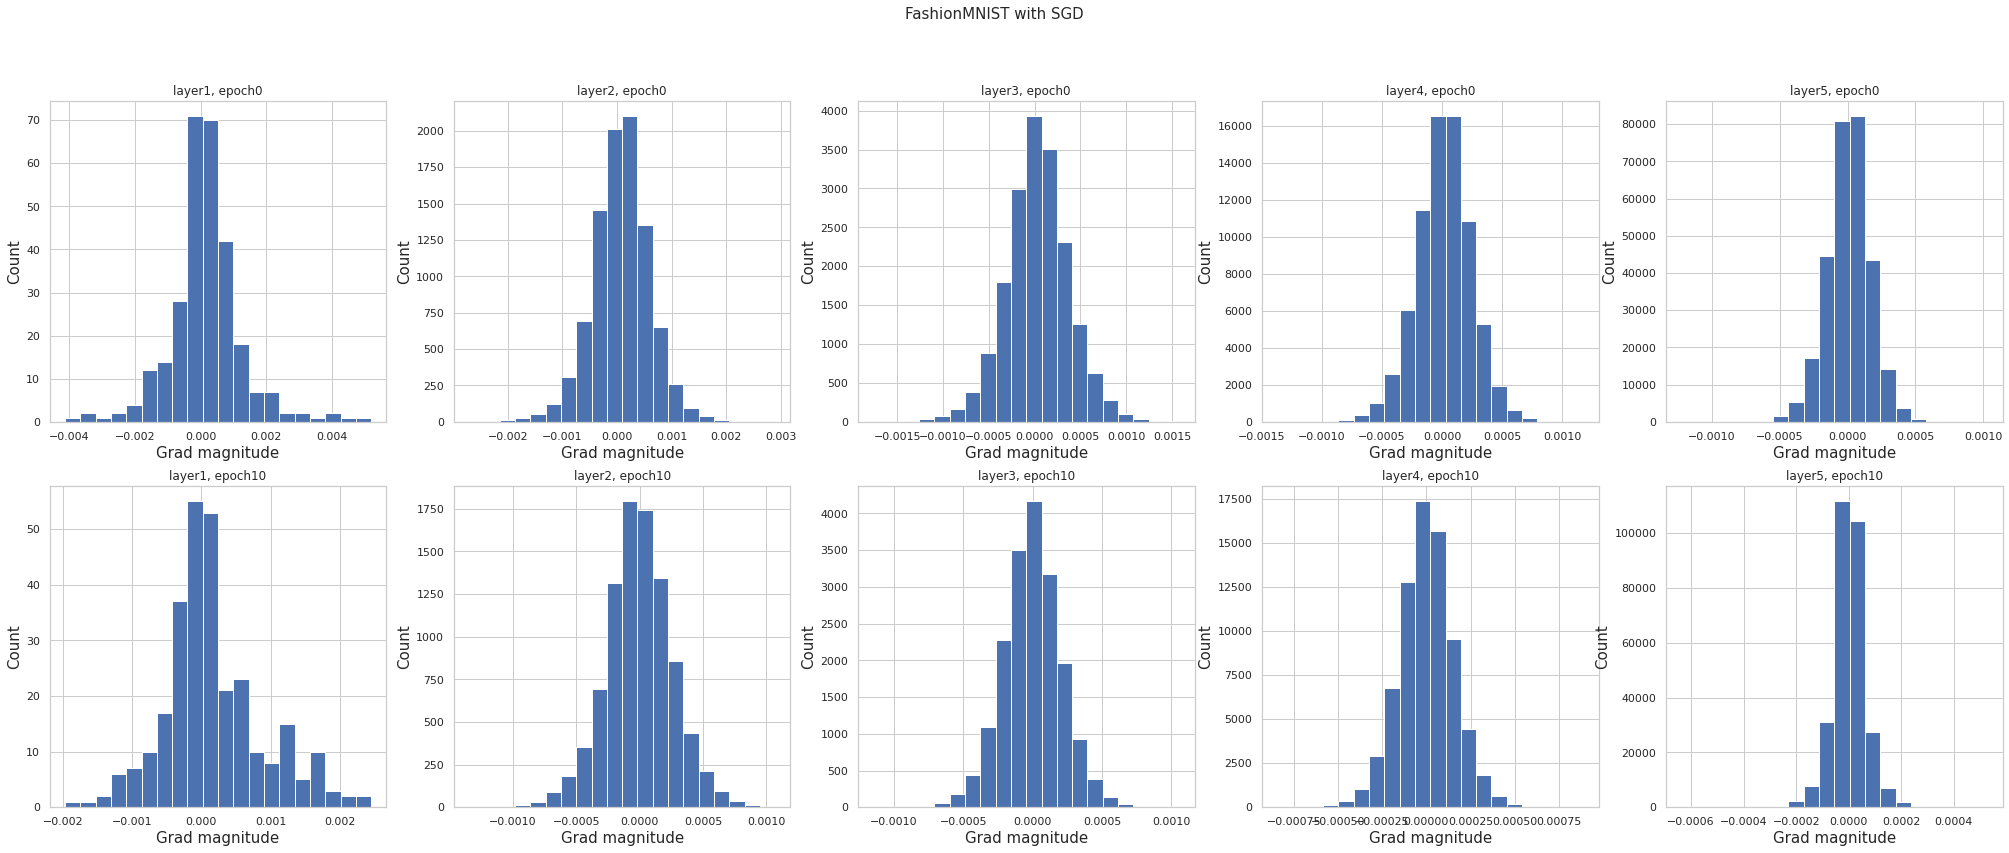

In [37]:
net = ResNet18(depth=1).to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST with SGD')

In [38]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 91.530%


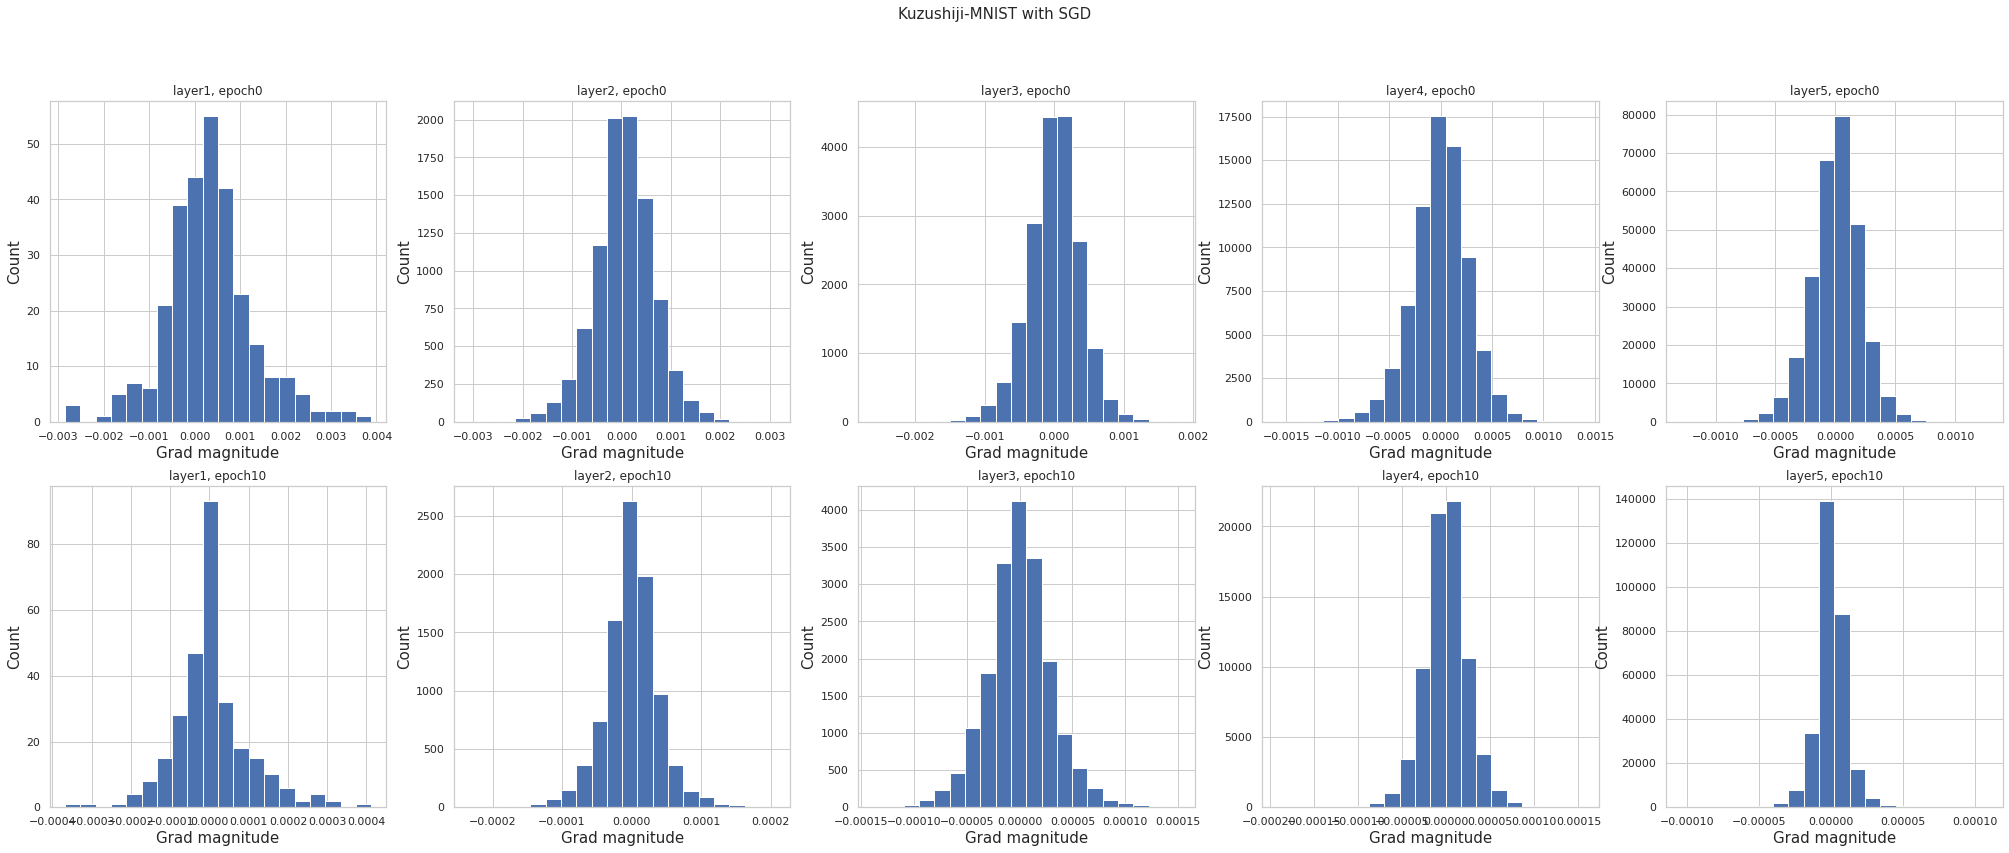

In [39]:
net = ResNet18(depth=1).to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST with SGD')

In [40]:
accuracy(net, testloader_kmnist)

Test's ac is: 95.490%


Заметим, что распределения градиентов стали намного уже, чем было с Adam. Сеть при этом на всех датасетах показала качество выше чем было во втором экперименте.

##Активации

Посмотрим на градиенты для сигмоидной функции активации

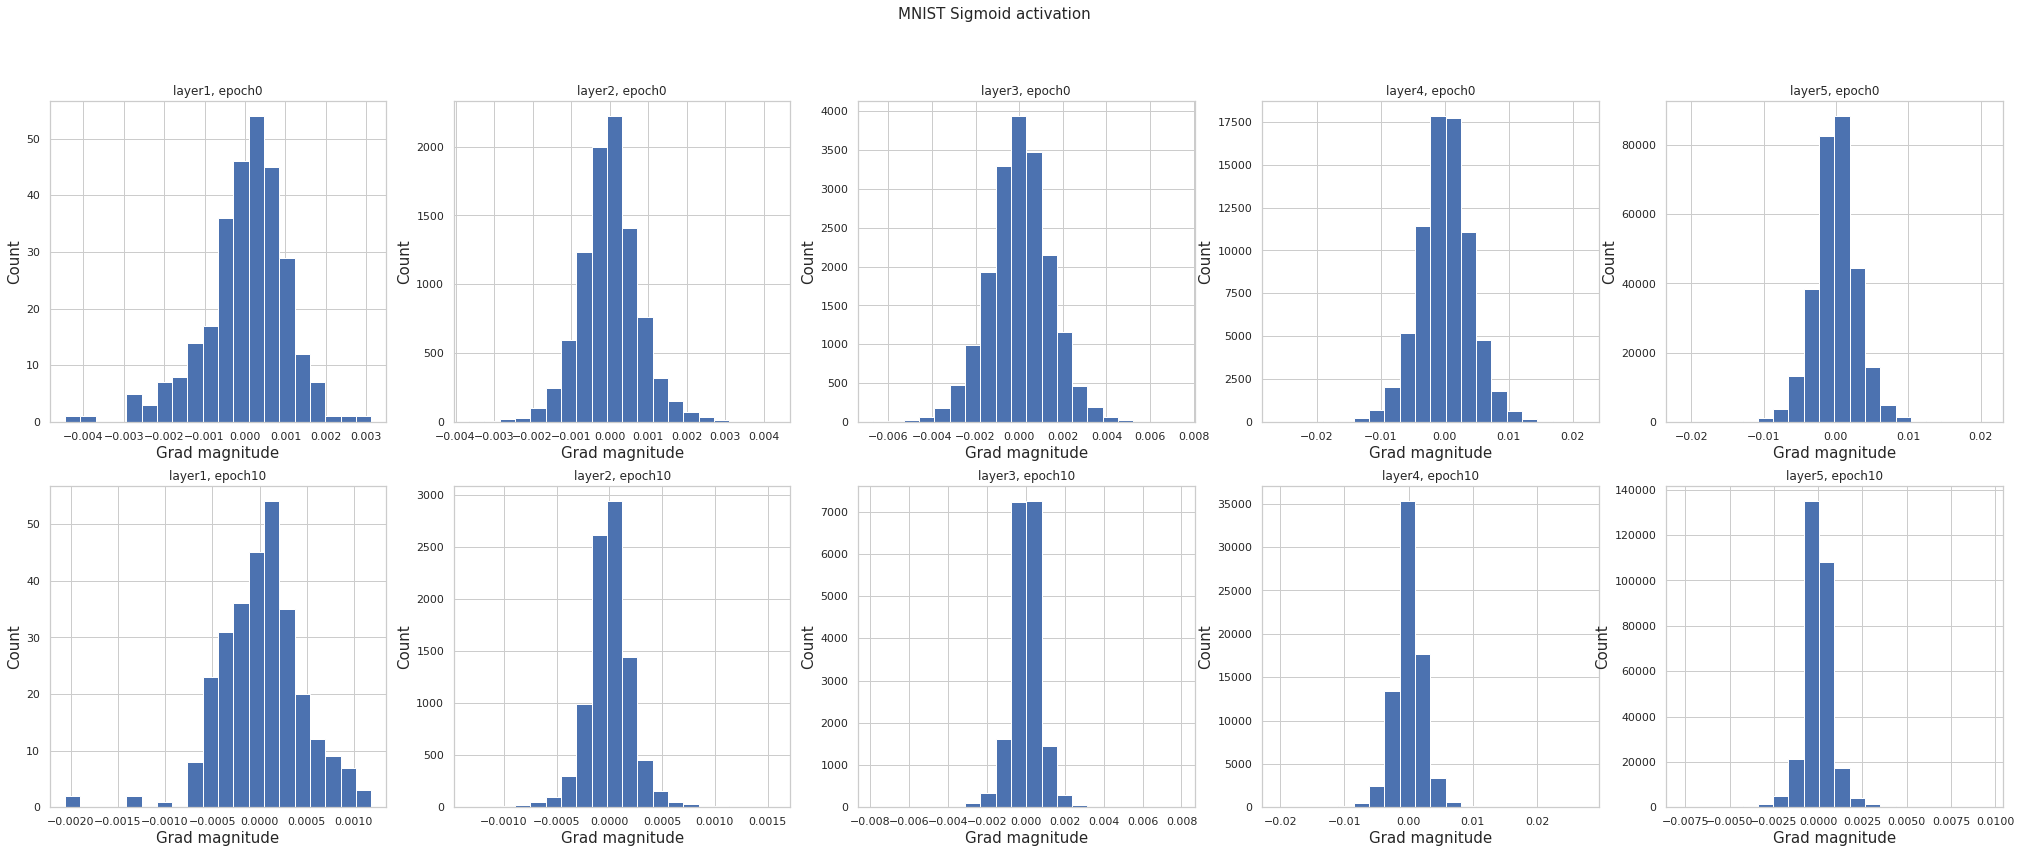

In [56]:
net = ResNet18(depth=1, activation=nn.Sigmoid()).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_mnist, testloader_mnist, 10, criterion, optimizer)
plot_grads(grads, 'MNIST Sigmoid activation')

In [45]:
accuracy(net, testloader_mnist)

Test's ac is: 97.510%


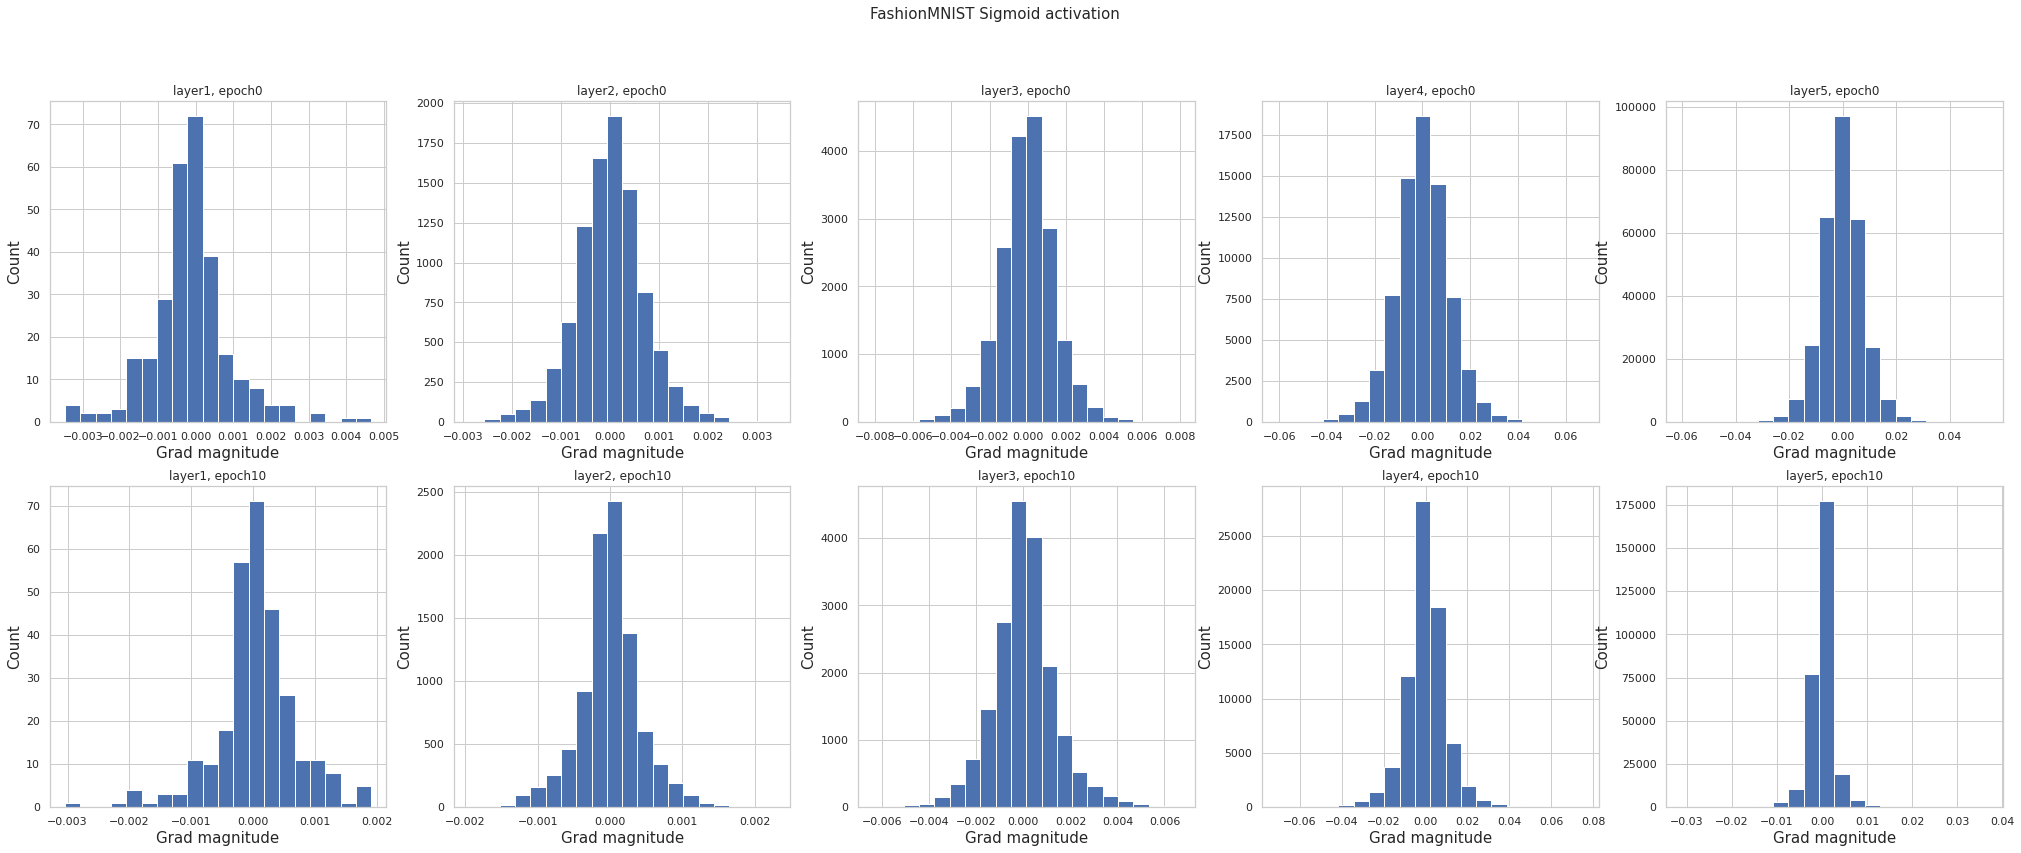

In [55]:
net = ResNet18(depth=1, activation=nn.Sigmoid()).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_fashin_mnist, testloader_fashin_mnist, 10, criterion, optimizer)
plot_grads(grads, 'FashionMNIST Sigmoid activation')

In [48]:
accuracy(net, testloader_fashin_mnist)

Test's ac is: 84.480%


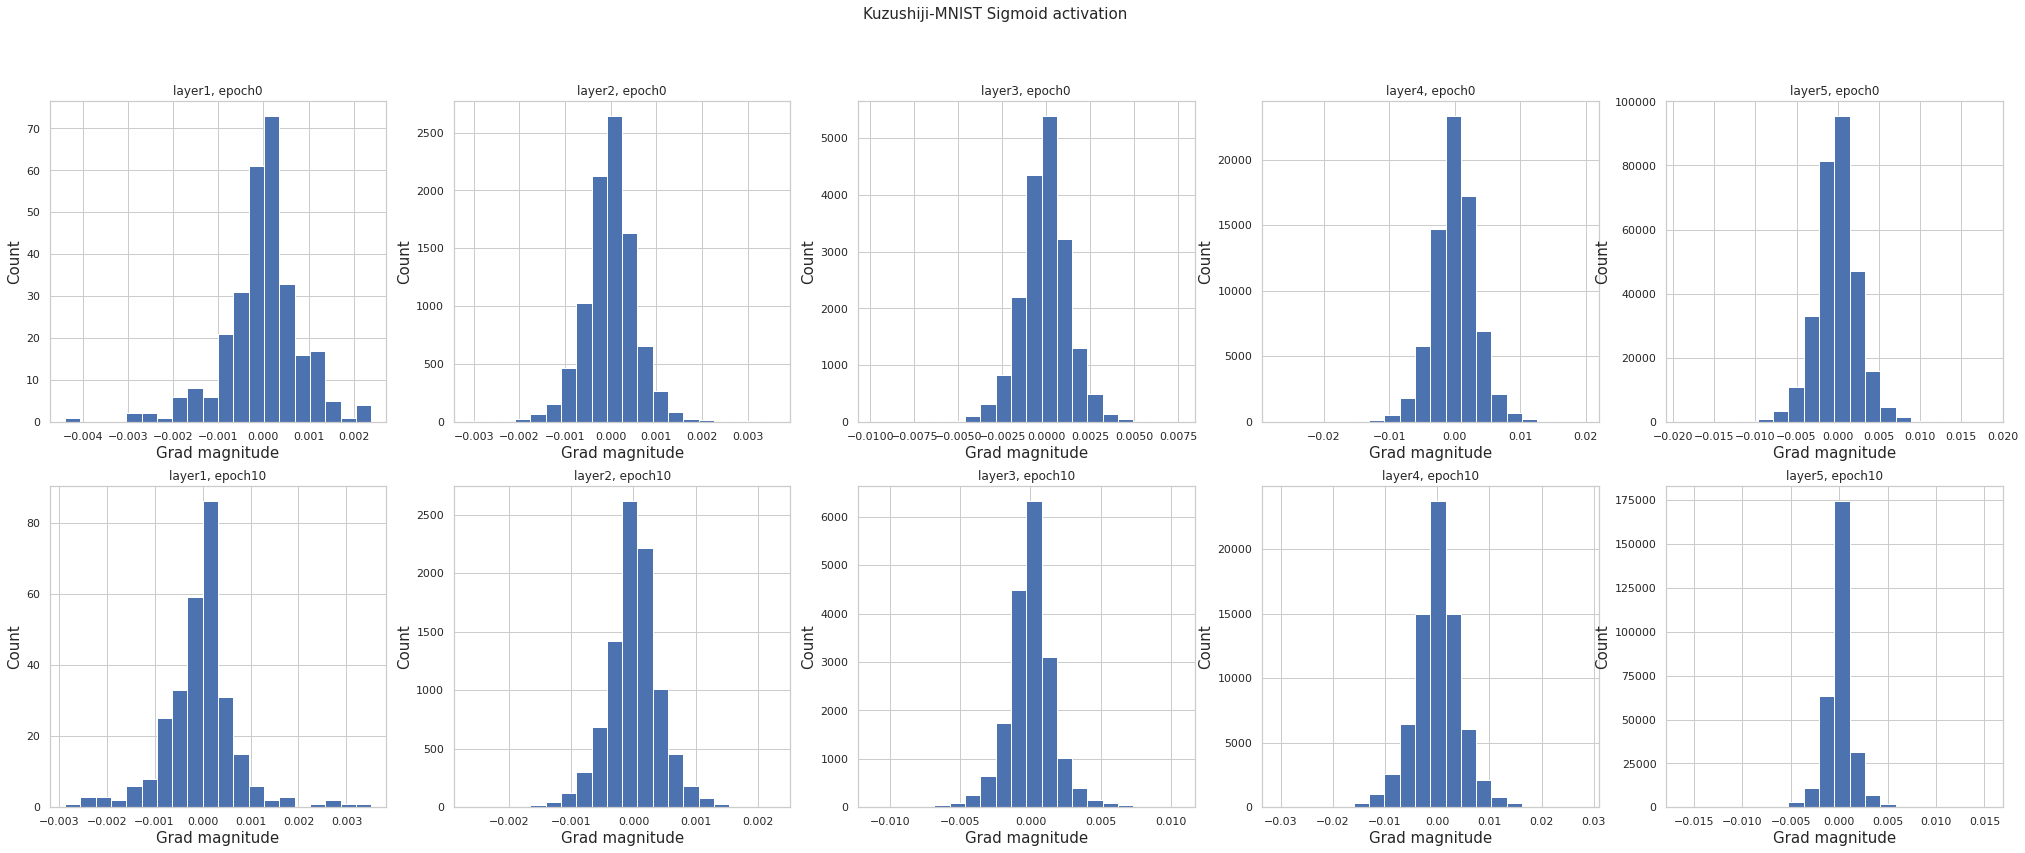

In [57]:
net = ResNet18(depth=1, activation=nn.Sigmoid()).to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-5)
grads = train(net, trainloader_kmnist, testloader_kmnist, 10, criterion, optimizer)
plot_grads(grads, 'Kuzushiji-MNIST Sigmoid activation')

In [50]:
accuracy(net, testloader_kmnist)

Test's ac is: 82.720%


Можно увидеть, что градиенты на последних слоях больше, чем на первых. Это говорит о затухании градиентов. Также заметим, что на последних эпохах значения практически не отличаются от первых эпох. То есть сеть плохо учится (что и видно из низкого качества на тесте).

##Выводы

Из проделанных экспериметов можно заключить, что для хорошего обучения сети необходимо бороться с затуханием градиента. Во многом помогает техника пробрасывания градиентов skip-connection. Так же для их стабилизации нужно использовать BatchNorm. Тогда распределение градиентов очень похоже на нормальное со средним в нуле. Использование DropOut без нормализации не приносит хорошего эффекта, возможно стоит их объеденить, чтобы улучшить распределения и тем самым качество обучения сети. Глубина и ширина не сильно влияют. Отметим, что необходимо правильно подходить к вопросу выбора инициализации весов и оптимизатора. В некоторых случаях это может помочь, а в некоторых наоборот. Было показано что в качестве функции активации стоит использовать ReLU, а не сигмоиду, которая может привести к затуханию градиента и тем самым плохому обучению.